In [2]:
#!/usr/bin/env python3
import argparse
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import pdist

def read_data(maf_file: Path, cnv_file: Path) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Reads the MAF and CNV files."""
    somatic_mutations_data = pd.read_csv(maf_file, sep='\t')
    copy_number_data = pd.read_csv(cnv_file)
    return somatic_mutations_data, copy_number_data


def build_gene_chrom_dict(somatic_mutations_data: pd.DataFrame,
                          gene_chrom_file: Optional[Path]
                          ) -> Tuple[Dict[str, str], Optional[pd.DataFrame]]:
    """
    Builds a gene-to-chromosome mapping.
    If gene_chrom_file is provided and contains location information (5 columns), it returns:
      - a dictionary mapping gene to chromosome (for plotting), and
      - a DataFrame with gene location info (used for sorting by genomic position).
    Otherwise, it falls back to using the MAF file.

    After building, filters out invalid chromosome labels like 'Chromosome/scaffold name' or 'NA'.
    """
    gene_info_df = None
    if gene_chrom_file is not None:
        try:
            # Attempt to read a file with location info: Gene, Ensembl, Chromosome, Start, End
            gene_info_df = pd.read_csv(gene_chrom_file, sep='\t', header=None,
                                       names=["Gene", "Ensembl", "Chromosome", "Start", "End"])
            gene_info_df.set_index("Gene", inplace=True)
            gene_chrom_dict = gene_info_df["Chromosome"].to_dict()
        except Exception:
            # Fallback if file has only two columns: Gene, Chromosome
            gene_chrom_map = pd.read_csv(gene_chrom_file, sep='\t', header=None, names=["Gene", "Chromosome"])
            gene_chrom_dict = gene_chrom_map.set_index("Gene")["Chromosome"].to_dict()
    else:
        gene_chrom_dict = somatic_mutations_data.groupby("Hugo_Symbol")["Chromosome"].first().to_dict()

    # Filter out invalid chromosome labels that often sneak in.
    invalid_labels = {"Chromosome/scaffold name", "NA"}
    gene_chrom_dict = {g: c for g, c in gene_chrom_dict.items() if c not in invalid_labels}

    return gene_chrom_dict, gene_info_df


def get_recurrent_genes(somatic_mutations_data: pd.DataFrame,
                        copy_number_data: pd.DataFrame,
                        num_recurrent_samples: int,
                        include_option: int,
                        gene_chrom_dict: Optional[Dict[str, str]] = None) -> List[str]:
    """Identifies recurrently altered genes based on the provided include_option."""
    maf_gene_counts = somatic_mutations_data['Hugo_Symbol'].value_counts()
    maf_recurrent_genes = set(maf_gene_counts[maf_gene_counts >= num_recurrent_samples].index)

    cnv_gene_counts = copy_number_data.iloc[:, 1:].apply(lambda x: (x != 0).sum(), axis=0)
    cnv_recurrent_genes = set(cnv_gene_counts[cnv_gene_counts >= num_recurrent_samples].index)

    if include_option == 1:
        recurrent_genes = maf_recurrent_genes & cnv_recurrent_genes
    elif include_option == 2:
        recurrent_genes = maf_recurrent_genes | cnv_recurrent_genes
    else:
        raise ValueError("Invalid value for include_option. Use 1 for both or 2 for either.")

    # Keep only genes present in the CNV file and, if applicable, in the gene_chrom mapping.
    recurrent_genes = [gene for gene in recurrent_genes if gene in copy_number_data.columns]
    if gene_chrom_dict is not None:
        recurrent_genes = [gene for gene in recurrent_genes if gene in gene_chrom_dict]
    return recurrent_genes


def prepare_cnv_heatmap_data(copy_number_data: pd.DataFrame, recurrent_genes: List[str]) -> pd.DataFrame:
    """Extracts and processes CNV data for recurrent genes.
    
    Converts log2 values to:
      1 if value > 0,
     -1 if value < 0,
      0 if value == 0.
    """
    cna_data = copy_number_data[['Unnamed: 0'] + recurrent_genes].set_index('Unnamed: 0')
    # Use np.sign to vectorize the transformation.
    return pd.DataFrame(np.sign(cna_data), index=cna_data.index, columns=cna_data.columns)


def prepare_mutations_data(somatic_mutations_data: pd.DataFrame, recurrent_genes: List[str]) -> pd.DataFrame:
    """Pivots the somatic mutation data for recurrent genes."""
    mutations_filtered = somatic_mutations_data[somatic_mutations_data['Hugo_Symbol'].isin(recurrent_genes)]
    mutations_pivot = mutations_filtered.pivot_table(index='Tumor_Sample_Barcode',
                                                     columns='Hugo_Symbol',
                                                     aggfunc='size',
                                                     fill_value=0)
    return mutations_pivot.reindex(columns=recurrent_genes, fill_value=0)


def align_samples(cna_heatmap_data: pd.DataFrame,
                  mutations_pivot: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, List[str]]:
    """Ensures that both CNV and mutation data are aligned to the same sample order."""
    all_samples = sorted(set(cna_heatmap_data.index).union(mutations_pivot.index))
    aligned_cna = cna_heatmap_data.reindex(all_samples).fillna(0).astype(int)
    aligned_mutations = mutations_pivot.reindex(all_samples).fillna(0).astype(int)
    return aligned_cna, aligned_mutations, all_samples


def combine_cell_value(cna_value: int, mutation_count: int) -> int:
    """
    Combine CNA value with mutation count.
    Returns:
      3  if gain (1) and mutation (>0),
     -3  if loss (-1) and mutation (>0),
      2  if neutral (0) and mutation (>0),
      or the original CNA value if no mutation.
    """
    if mutation_count > 0:
        if cna_value == 1:
            return 3
        elif cna_value == -1:
            return -3
        else:
            return 2
    return cna_value


def combine_alterations(aligned_cna: pd.DataFrame,
                        aligned_mutations: pd.DataFrame) -> pd.DataFrame:
    """Combine CNA and mutation data cell by cell."""
    combined = aligned_cna.copy()
    for sample in aligned_mutations.index:
        for gene in aligned_mutations.columns:
            mutation_count = aligned_mutations.loc[sample, gene]
            combined.loc[sample, gene] = combine_cell_value(combined.loc[sample, gene], mutation_count)
    return combined


# ----------------- Clustering Helper ----------------- #

def cluster_samples(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clusters the samples (rows) of the DataFrame based on their genomic alteration profiles.
    Returns a new DataFrame with rows reordered according to hierarchical clustering.
    """
    if df.shape[0] < 2:
        return df
    # Compute pairwise Euclidean distances and then the linkage matrix using average linkage.
    distances = pdist(df.values, metric='euclidean')
    linkage_matrix = linkage(distances, method='average')
    order = leaves_list(linkage_matrix)
    return df.iloc[order]


# ----------------- Plotting Helpers ----------------- #

def draw_alteration_cell(ax, gene_index: int, sample_index: int, value: int) -> None:
    """
    Draws a single cell on the oncoprint with borders.
    Mapping:
      1  -> CNA gain (lightpink),
     -1  -> CNA loss (lightblue),
      2  -> mutation only (white, with marker),
      3  -> gain + mutation,
     -3  -> loss + mutation.
    In all cases, a black border is drawn.
    """
    mapping = {
        1: ('lightpink', False),
        -1: ('lightblue', False),
        2: (None, True),
        3: ('lightpink', True),
        -3: ('lightblue', True)
    }
    rect_color, marker_flag = mapping.get(value, (None, False))
    
    # Always draw a rectangle with a black border.
    # Use the alteration color if available, otherwise default to white.
    cell_patch = mpatches.Rectangle((gene_index, sample_index), 1, 1,
                                    facecolor=rect_color if rect_color is not None else 'white',
                                    edgecolor='black', linewidth=0.5, zorder=1)
    ax.add_patch(cell_patch)
    
    if marker_flag:
        ax.plot(gene_index + 0.5, sample_index + 0.5, marker='*',
                color='red', markersize=10, zorder=2)


def draw_alteration_grid(ax, ordered_data: pd.DataFrame) -> None:
    """Loops over the data grid and draws each cell."""
    for sample_index, sample in enumerate(ordered_data.index):
        for gene_index, gene in enumerate(ordered_data.columns):
            value = ordered_data.loc[sample, gene]
            draw_alteration_cell(ax, gene_index, sample_index, value)


def setup_main_axis(ax, ordered_data: pd.DataFrame) -> None:
    """Configures the main axis with ticks, labels, and limits."""
    gene_labels = [f"$\\it{{{gene}}}$" for gene in ordered_data.columns]
    ax.set_xticks(np.arange(len(ordered_data.columns)) + 0.5)
    ax.set_xticklabels(gene_labels, rotation=90)
    ax.set_yticks(np.arange(len(ordered_data.index)) + 0.5)
    ax.set_yticklabels(ordered_data.index)
    ax.set_xlim(0, len(ordered_data.columns))
    ax.set_ylim(0, len(ordered_data.index))
    ax.invert_yaxis()


def add_chromosome_twin_axis(ax, ordered_data: pd.DataFrame,
                             gene_chrom_dict: Dict[str, str]) -> Dict[str, any]:
    """
    Adds a twin x-axis to annotate chromosomes.
    Ensures that each chromosome is assigned a unique and consistent color across all plots,
    even when there are more than 20 chromosomes.
    Returns a dictionary with the twin axis, chrom_colors, and unique chromosomes.
    """
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())

    # Get the chromosome label for each gene in the plot.
    chrom_labels = [gene_chrom_dict.get(gene, "NA") for gene in ordered_data.columns]
    
    # Create a global set of all chromosomes from the gene_chrom_dict for consistent mapping.
    global_chroms = sorted(set(gene_chrom_dict.values()))
    N = len(global_chroms)

    # Use a colormap that can produce N discrete colors. 'gist_ncar' gives a wide variety of distinct colors.
    if N > 0:
        cmap = plt.cm.get_cmap('gist_ncar', N)
    else:
        cmap = plt.cm.get_cmap('gray', 1)

    global_chrom_color_mapping = {chrom: cmap(i) for i, chrom in enumerate(global_chroms)}
    
    # For the genes in the current plot, assign colors using the global mapping (default to grey if missing).
    chrom_colors = {chrom: global_chrom_color_mapping.get(chrom, 'grey') for chrom in set(chrom_labels)}
    
    ax2.set_xticks(np.arange(len(ordered_data.columns)) + 0.5)
    ax2.set_xticklabels([" "] * len(chrom_labels), rotation=90)
    ax2.xaxis.set_ticks_position("top")

    for label, chrom in zip(ax2.get_xticklabels(), chrom_labels):
        label.set_bbox(dict(facecolor=chrom_colors.get(chrom, 'grey'),
                            alpha=1, edgecolor='none', boxstyle='square,pad=0.2'))

    return {
        'ax2': ax2,
        'chrom_colors': global_chrom_color_mapping,  # full mapping for legend
        'unique_chroms': global_chroms
    }


def add_legends(ax, chrom_colors: dict, unique_chroms: list) -> None:
    """Adds legends for CNA alterations and chromosomes."""
    gain_patch = mpatches.Patch(color='lightpink', label='CNA Gain')
    loss_patch = mpatches.Patch(color='lightblue', label='CNA Loss')
    mutation_marker = plt.Line2D([0], [0], marker='*', color='w',
                                 label='Somatic Mutation', markerfacecolor='red', markersize=10)
    main_legend = ax.legend(handles=[gain_patch, loss_patch, mutation_marker],
                            loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0.)
    ax.add_artist(main_legend)

    # Build the chromosome legend from the global mapping (unique_chroms).
    chrom_patches = [mpatches.Patch(color=chrom_colors[ch], label=ch) for ch in unique_chroms]
    ax.legend(handles=chrom_patches, title="Chromosomes",
              loc='upper left', bbox_to_anchor=(1.02, 0.7), borderaxespad=0.)


def plot_oncoprint(ordered_data: pd.DataFrame,
                    gene_chrom_dict: Dict[str, str],
                    tumour_type: str,
                    plot_height: int,
                    plot_width: int,
                    output_file: Optional[Path],
                    x_label: str,
                    filtering_info: str) -> None:
    """Creates and displays (or saves) the oncoprint plot using helper functions.
    
    The filtering_info parameter is appended to the title to indicate the filtering criteria.
    """
    fig, ax = plt.subplots(figsize=(plot_width, plot_height))
    draw_alteration_grid(ax, ordered_data)
    setup_main_axis(ax, ordered_data)
    twin_info = add_chromosome_twin_axis(ax, ordered_data, gene_chrom_dict)
    plt.subplots_adjust(right=0.8)
    add_legends(ax, twin_info['chrom_colors'], twin_info['unique_chroms'])

    ax.set_title(f'Genetic Alterations (Somatic Mutations and Copy Number Variations) in {tumour_type}\n{filtering_info}')
    ax.set_xlabel(x_label)
    ax.set_ylabel('Samples')

    if output_file:
        plt.savefig(output_file, bbox_inches='tight')
    else:
        plt.show()


def order_genes_by_alterations(filtered_data: pd.DataFrame) -> pd.DataFrame:
    """Orders genes by the total number of alterations."""
    alteration_counts = (filtered_data != 0).sum(axis=0)
    ordered_genes = alteration_counts.sort_values(ascending=False).index
    return filtered_data[ordered_genes]


def filter_recurrent_genes_post_alignment(combined_heatmap_data: pd.DataFrame,
                                          aligned_mutations: pd.DataFrame,
                                          aligned_cna: pd.DataFrame,
                                          num_recurrent_samples: int,
                                          include_option: int) -> pd.DataFrame:
    """Post-process filtering of genes based on recurrent alterations across samples."""
    if include_option == 1:
        # Genes must have at least N samples with mutation AND N with CNV
        recurrent_mutation_genes = combined_heatmap_data.columns[(aligned_mutations > 0).sum(axis=0) >= num_recurrent_samples]
        recurrent_cnv_genes = combined_heatmap_data.columns[(aligned_cna.abs() > 0).sum(axis=0) >= num_recurrent_samples]
        recurrent_genes = list(set(recurrent_mutation_genes) & set(recurrent_cnv_genes))
    else:
        # Genes must have at least N samples with ANY alteration (mutation or CNV)
        recurrent_genes = combined_heatmap_data.columns[(combined_heatmap_data != 0).sum(axis=0) >= num_recurrent_samples]
    return combined_heatmap_data[recurrent_genes]


def generate_breakdown_table(ordered_data: pd.DataFrame) -> pd.DataFrame:
    """
    Generate a table that counts, for each gene, the number of samples that have:
      - CNA gain only (value = 1)
      - CNA loss only (value = -1)
      - Mutation only (value = 2)
      - Gain + Mutation (value = 3)
      - Loss + Mutation (value = -3)
    Also adds a column for the total number of alterations,
    and sorts by Total Alterations in descending order.
    """
    breakdown = pd.DataFrame(index=ordered_data.columns)
    breakdown['CNA Gain Only'] = (ordered_data == 1).sum(axis=0)
    breakdown['CNA Loss Only'] = (ordered_data == -1).sum(axis=0)
    breakdown['Mutation Only'] = (ordered_data == 2).sum(axis=0)
    breakdown['Gain + Mutation'] = (ordered_data == 3).sum(axis=0)
    breakdown['Loss + Mutation'] = (ordered_data == -3).sum(axis=0)
    breakdown['Total Alterations'] = (ordered_data != 0).sum(axis=0)
    
    # Sort by Total Alterations in descending order
    breakdown = breakdown.sort_values(by='Total Alterations', ascending=False)
    return breakdown


def generate_recurrent_gene_oncoprint(maf_file: Path,
                                      cnv_file: Path,
                                      tumour_type: str,
                                      num_recurrent_samples: int = 2,
                                      plot_height: int = 12,
                                      plot_width: int = 20,
                                      include_option: int = 2,
                                      output_file: Optional[Path] = None,
                                      gene_chrom_file: Optional[Path] = None,
                                      gene_sort: str = "alterations",
                                      cluster_samples_flag: bool = False,
                                      breakdown_file: Optional[Path] = None,
                                      exclude_file: Optional[Path] = None,
                                      include_samples: Optional[List[str]] = None) -> None:
    # Step 1: Read data
    somatic_mutations_data, copy_number_data = read_data(maf_file, cnv_file)

    # Step 1a: Build gene-to-chromosome mapping and gene location info.
    gene_chrom_dict, gene_info_df = build_gene_chrom_dict(somatic_mutations_data, gene_chrom_file)

    # Step 2 & 3: Identify recurrent genes.
    recurrent_genes = get_recurrent_genes(somatic_mutations_data,
                                          copy_number_data,
                                          num_recurrent_samples,
                                          include_option,
                                          gene_chrom_dict if gene_chrom_file is not None else None)

    # Step 4: Prepare CNV and mutation data.
    cna_heatmap_data = prepare_cnv_heatmap_data(copy_number_data, recurrent_genes)
    mutations_pivot = prepare_mutations_data(somatic_mutations_data, recurrent_genes)

    # Step 5: Align sample order across datasets.
    aligned_cna, aligned_mutations, all_samples = align_samples(cna_heatmap_data, mutations_pivot)

    # Optional: Filter to include only desired samples.
    if include_samples is not None:
        aligned_cna = aligned_cna.loc[aligned_cna.index.intersection(include_samples)]
        aligned_mutations = aligned_mutations.loc[aligned_mutations.index.intersection(include_samples)]

    if exclude_file:
        with open(exclude_file, 'r') as ef:
            exclude_samples = {line.strip() for line in ef if line.strip()}
        aligned_cna = aligned_cna[~aligned_cna.index.isin(exclude_samples)]
        aligned_mutations = aligned_mutations[~aligned_mutations.index.isin(exclude_samples)]

    # Step 6: Combine the CNA and mutation data.
    combined_heatmap_data = combine_alterations(aligned_cna, aligned_mutations)

    # Step 7: Filter genes based on recurrence post-alignment.
    filtered_data = filter_recurrent_genes_post_alignment(combined_heatmap_data,
                                                          aligned_mutations,
                                                          aligned_cna,
                                                          num_recurrent_samples,
                                                          include_option)

    # Step 8: Order genes (columns).
    ordered_data = order_genes_by_alterations(filtered_data)

    # If gene_sort is 'position', reorder genes based on genomic coordinates.
    if gene_sort == "position":
        if gene_info_df is None:
            raise ValueError("Genomic position sorting requested but no gene_chrom_file with location info provided.")
        # Subset gene_info_df to the genes present in ordered_data.
        gene_info_sub = gene_info_df.loc[ordered_data.columns]
        # Sort by Chromosome and then by Start coordinate.
        sorted_genes = gene_info_sub.sort_values(by=["Chromosome", "Start"]).index.tolist()
        ordered_data = ordered_data[sorted_genes]
        x_label = "Genes (Ordered by Genomic Position)"
    else:
        x_label = "Genes (Ordered by Number of Alterations)"

    # Optionally cluster samples (rows) if requested.
    if cluster_samples_flag:
        ordered_data = cluster_samples(ordered_data)

    # Generate the breakdown table (now sorted by total alterations).
    breakdown_table = generate_breakdown_table(ordered_data)
    if breakdown_file:
        breakdown_table.to_csv(breakdown_file)
        print(f"Breakdown table written to {breakdown_file}")
    else:
        print("Breakdown of alterations per gene (sorted by Total Alterations):")
        print(breakdown_table)

    # Create a filtering information string for the title.
    if include_option == 1:
        filter_method = "both alterations"
    else:
        filter_method = "either alteration"
    filtering_info = f"Filtered: ≥ {num_recurrent_samples} samples with {filter_method}"

    # Step 9: Plot the oncoprint.
    plot_oncoprint(ordered_data, gene_chrom_dict, tumour_type,
                   plot_height, plot_width, output_file, x_label, filtering_info)

In [3]:
maf_files = sorted([file for file in Path("/lustre/scratch127/bf14/analysis/maf_files/").glob("keepPA*.maf")])
cnv_files = sorted([file for file in Path("/lustre/scratch127/bf14/analysis/fur_cnvkit/run_cnvkit_copy_number_calling_pipeline/all_studies_farm22/").glob("????_*/*.genemetrics_study_summary.csv")])


In [4]:
def get_study_name(cnv_file: Path) -> str:
    return cnv_file.name.split(".")[0]

Breakdown table written to 6555_Lung_carcinoma_oncoprint_breakdown.csv


/tmp/ipykernel_1765869/3466254326.py:232: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('gist_ncar', N)


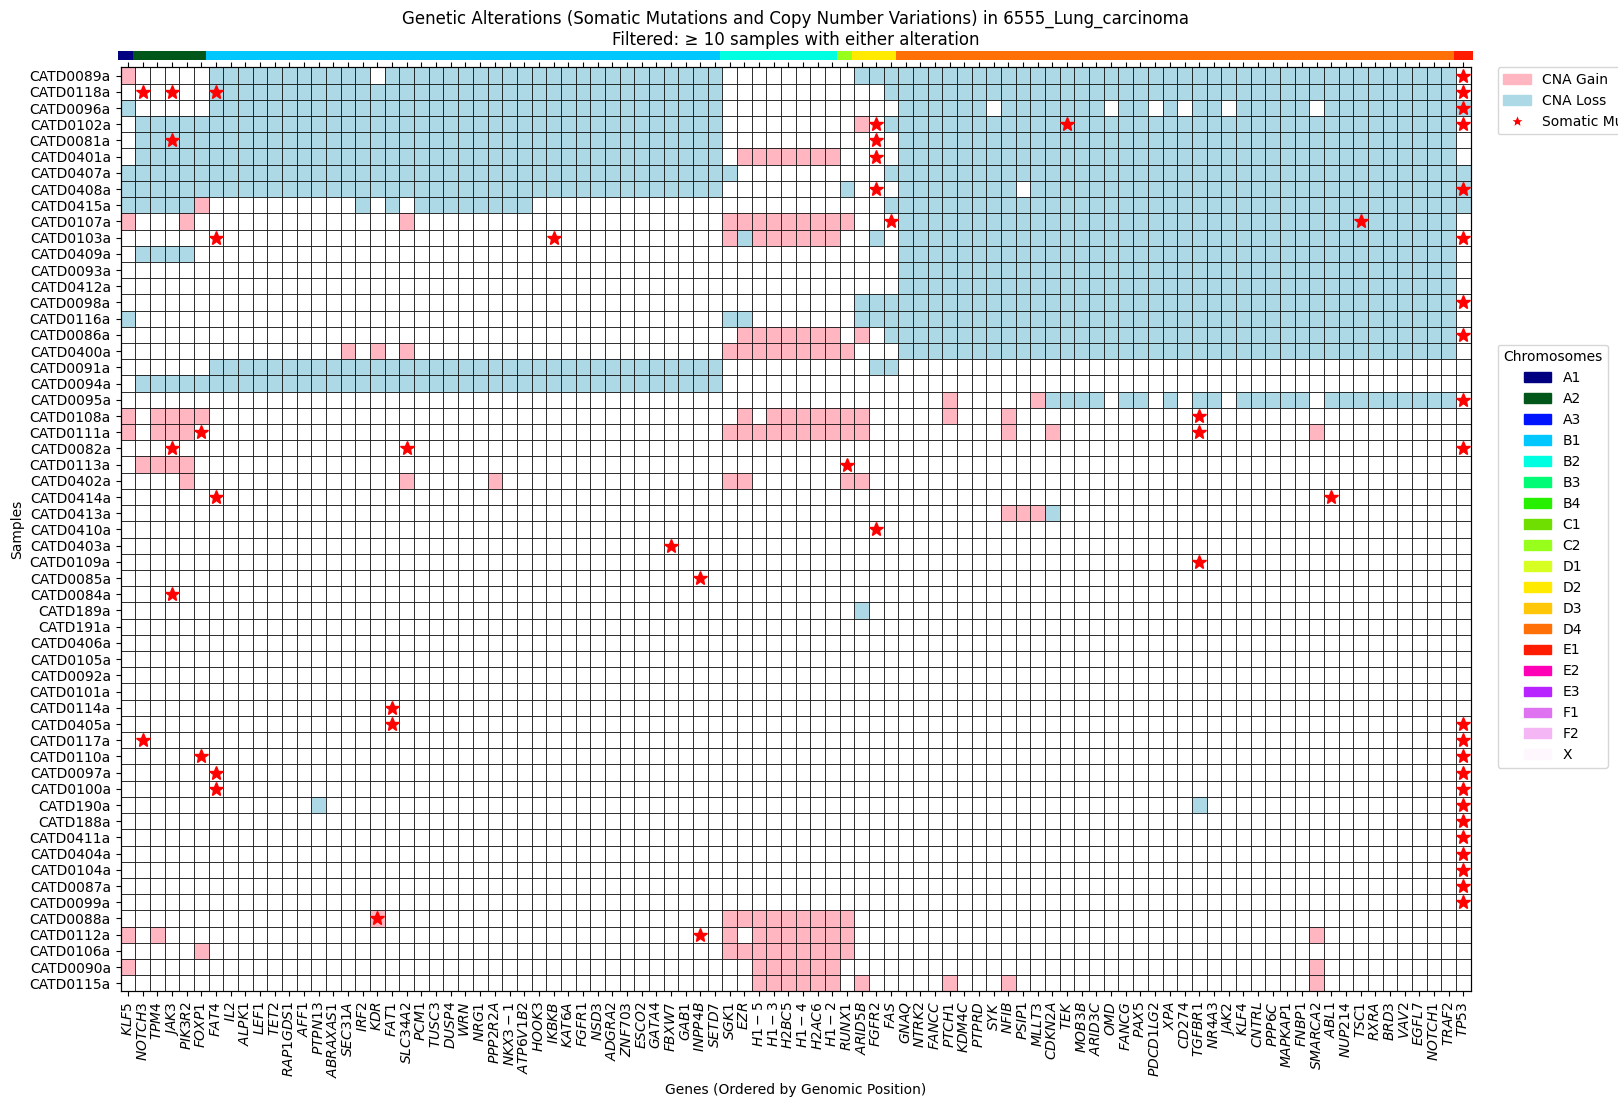

In [13]:
generate_recurrent_gene_oncoprint(
    maf_file=maf_files[0],
    cnv_file=cnv_files[0],
    tumour_type=get_study_name(cnv_files[0]),
    num_recurrent_samples=10,
    gene_chrom_file="/lustre/scratch127/bf14/analysis/fur_cnvkit/oncoprints/Felis_catus_9.0.gene_chromosome_mapping.txt",
    gene_sort="position",
    cluster_samples_flag=True,
    output_file=f"{get_study_name(cnv_files[0])}_oncoprint.pdf",
    breakdown_file=f"{get_study_name(cnv_files[0])}_oncoprint_breakdown.csv",
    exclude_file="/lustre/scratch127/bf14/metadata/FUR_cat.samples_to_exclude.nucleotide_variants.txt"
)

Breakdown table written to 6711_Cutaneous_SCC_oncoprint_breakdown.csv


/tmp/ipykernel_1765869/3466254326.py:232: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('gist_ncar', N)


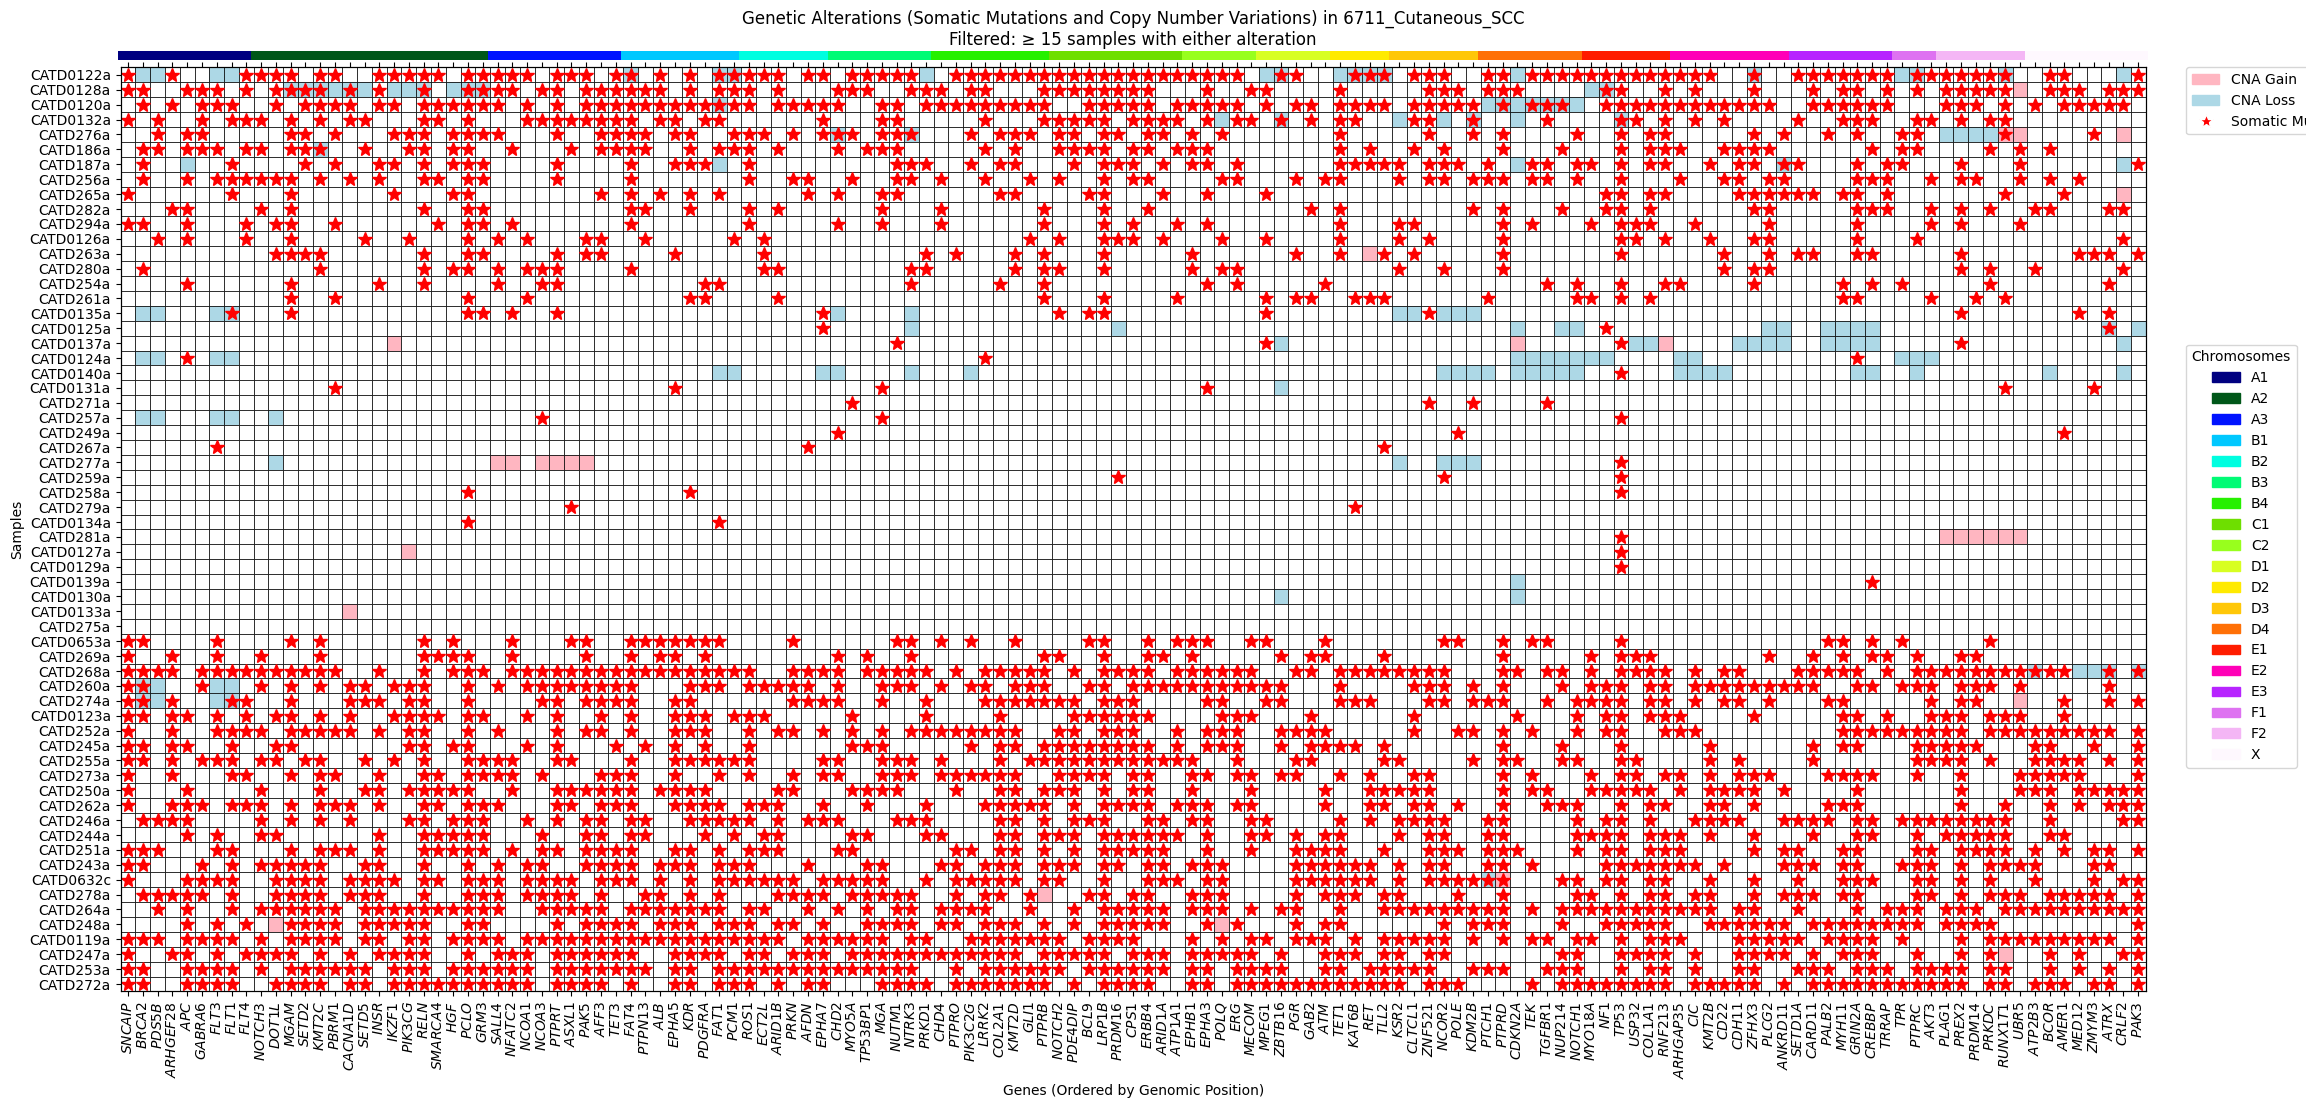

In [14]:
generate_recurrent_gene_oncoprint(
    maf_file=maf_files[1],
    cnv_file=cnv_files[1],
    tumour_type=get_study_name(cnv_files[1]),
    num_recurrent_samples=15,
    gene_chrom_file="/lustre/scratch127/bf14/analysis/fur_cnvkit/oncoprints/Felis_catus_9.0.gene_chromosome_mapping.txt",
    gene_sort="position",
    cluster_samples_flag=True,
    output_file=f"{get_study_name(cnv_files[1])}_oncoprint.pdf",
    breakdown_file=f"{get_study_name(cnv_files[1])}_oncoprint_breakdown.csv",
    plot_width=30,
    exclude_file="/lustre/scratch127/bf14/metadata/FUR_cat.samples_to_exclude.nucleotide_variants.txt"
)

Breakdown table written to 6712_Oral_SCC_oncoprint_breakdown.csv


/tmp/ipykernel_1773295/3466254326.py:232: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('gist_ncar', N)


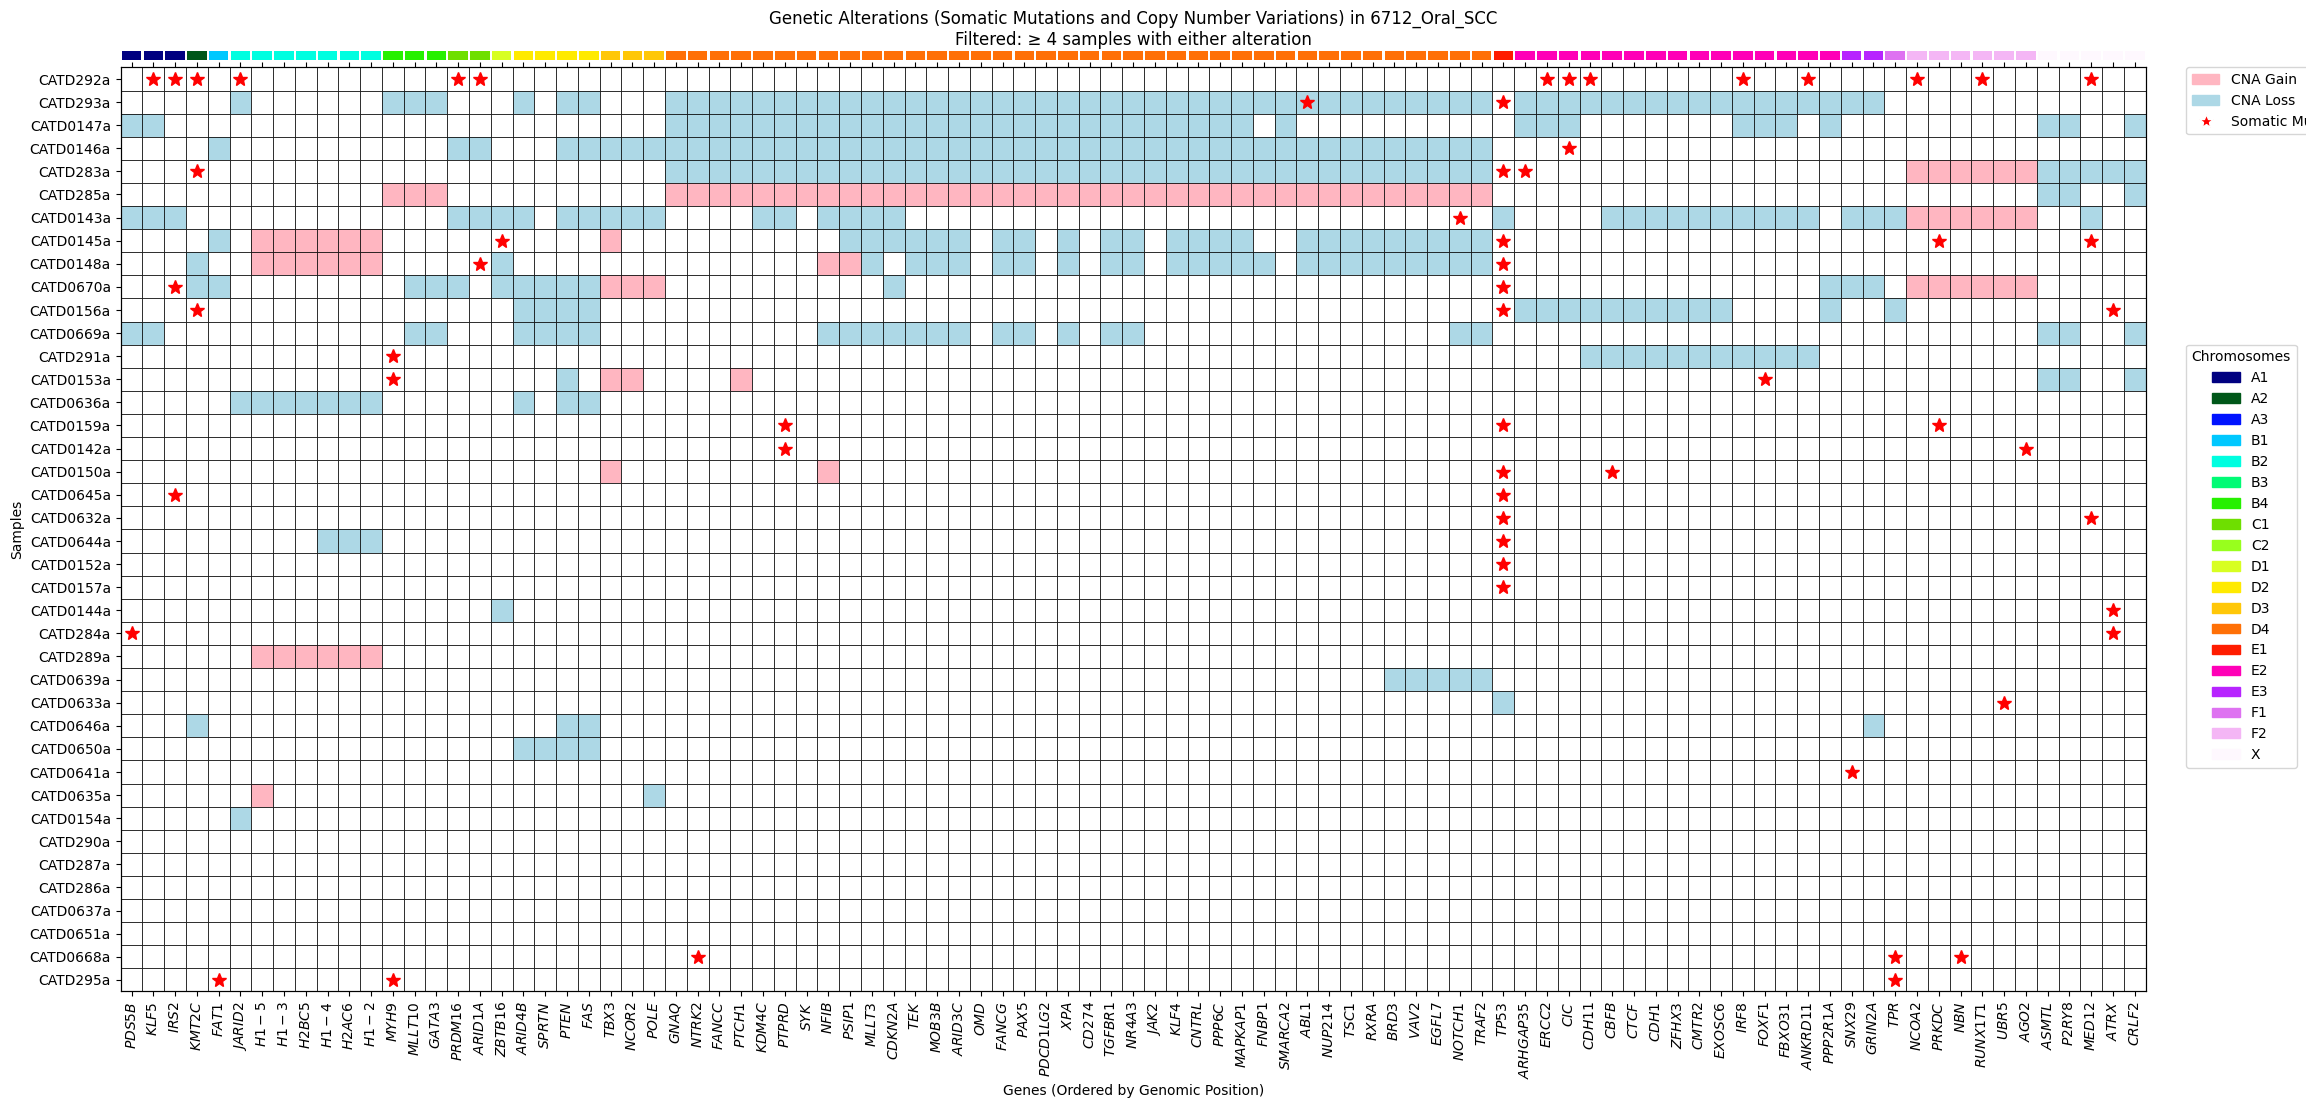

In [5]:
generate_recurrent_gene_oncoprint(
    maf_file=maf_files[2],
    cnv_file=cnv_files[2],
    tumour_type=get_study_name(cnv_files[2]),
    num_recurrent_samples=4,
    gene_chrom_file="/lustre/scratch127/bf14/analysis/fur_cnvkit/oncoprints/Felis_catus_9.0.gene_chromosome_mapping.txt",
    gene_sort="position",
    cluster_samples_flag=True,
    output_file=f"{get_study_name(cnv_files[2])}_oncoprint.pdf",
    breakdown_file=f"{get_study_name(cnv_files[2])}_oncoprint_breakdown.csv",
    plot_width=30,
    exclude_file="/lustre/scratch127/bf14/metadata/FUR_cat.samples_to_exclude.nucleotide_variants.txt"
)

Breakdown table written to 6713_Cutaneous_MCT_oncoprint_breakdown.csv


/tmp/ipykernel_1765869/3466254326.py:232: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('gist_ncar', N)


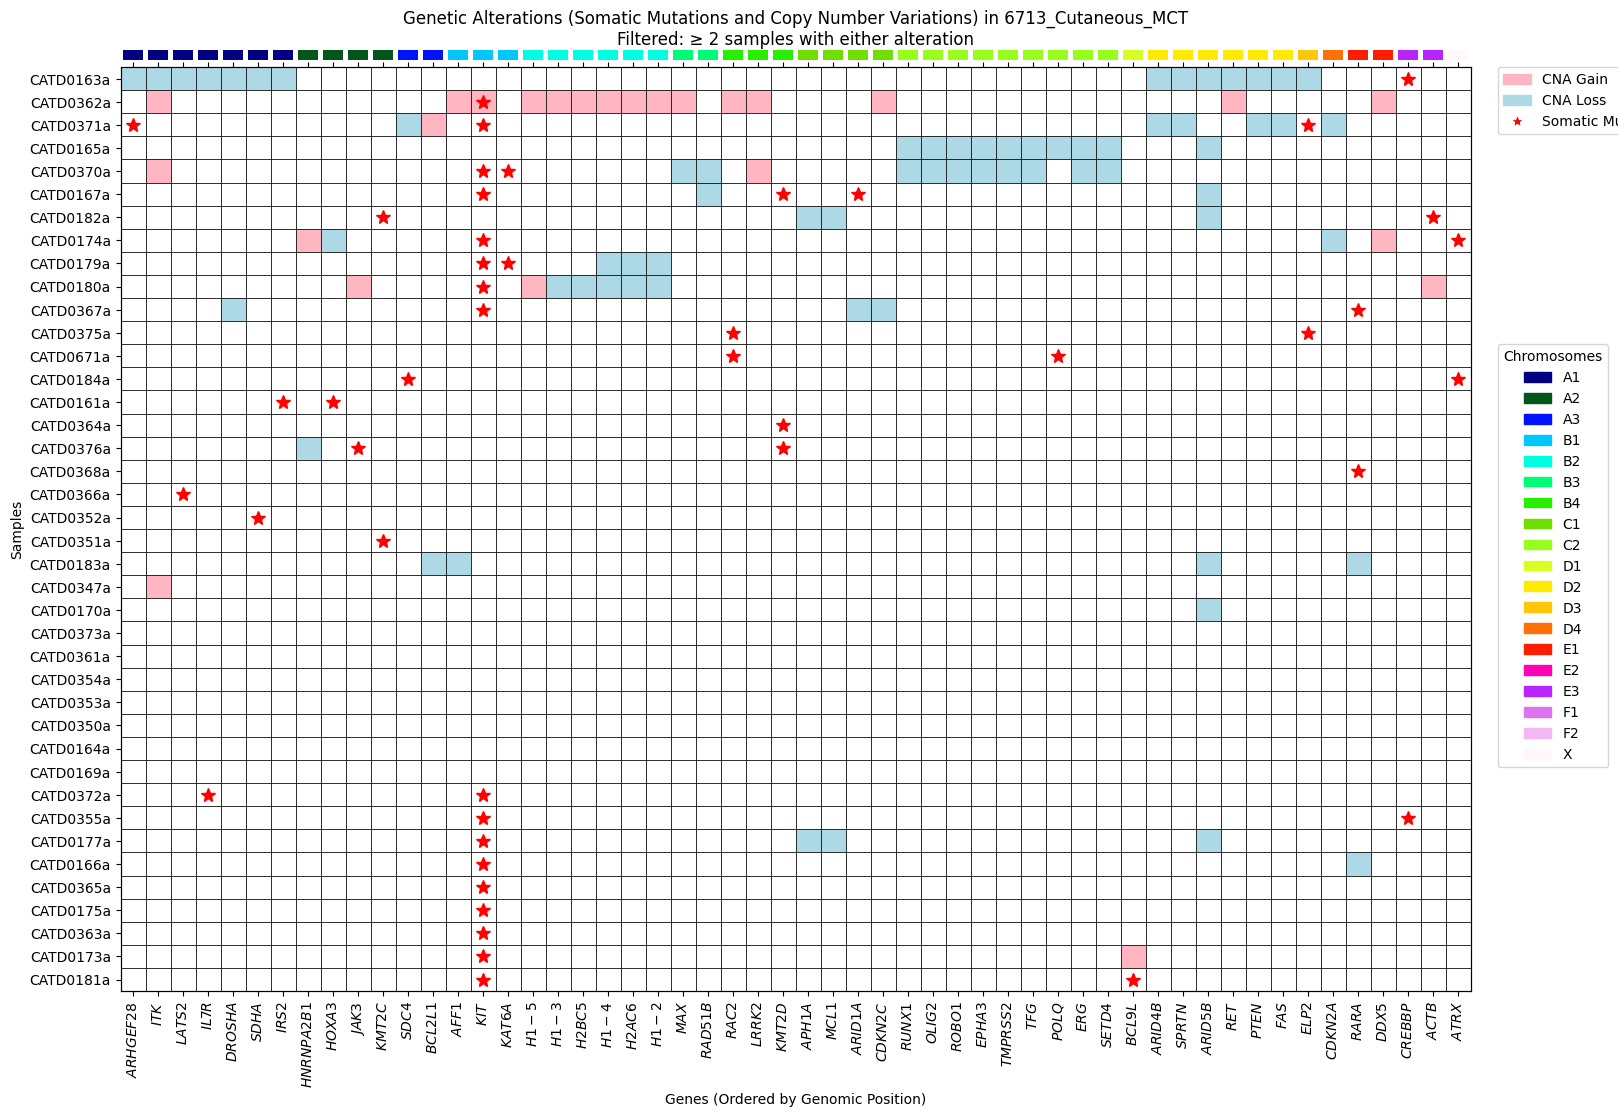

In [16]:
generate_recurrent_gene_oncoprint(
    maf_file=maf_files[3],
    cnv_file=cnv_files[3],
    tumour_type=get_study_name(cnv_files[3]),
    num_recurrent_samples=2,
    gene_chrom_file="/lustre/scratch127/bf14/analysis/fur_cnvkit/oncoprints/Felis_catus_9.0.gene_chromosome_mapping.txt",
    gene_sort="position",
    cluster_samples_flag=True,
    output_file=f"{get_study_name(cnv_files[3])}_oncoprint.pdf",
    breakdown_file=f"{get_study_name(cnv_files[3])}_oncoprint_breakdown.csv",
    exclude_file="/lustre/scratch127/bf14/metadata/FUR_cat.samples_to_exclude.nucleotide_variants.txt"
)

Breakdown table written to 6841_Meningioma_oncoprint_breakdown.csv


/tmp/ipykernel_1765869/3466254326.py:232: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('gist_ncar', N)


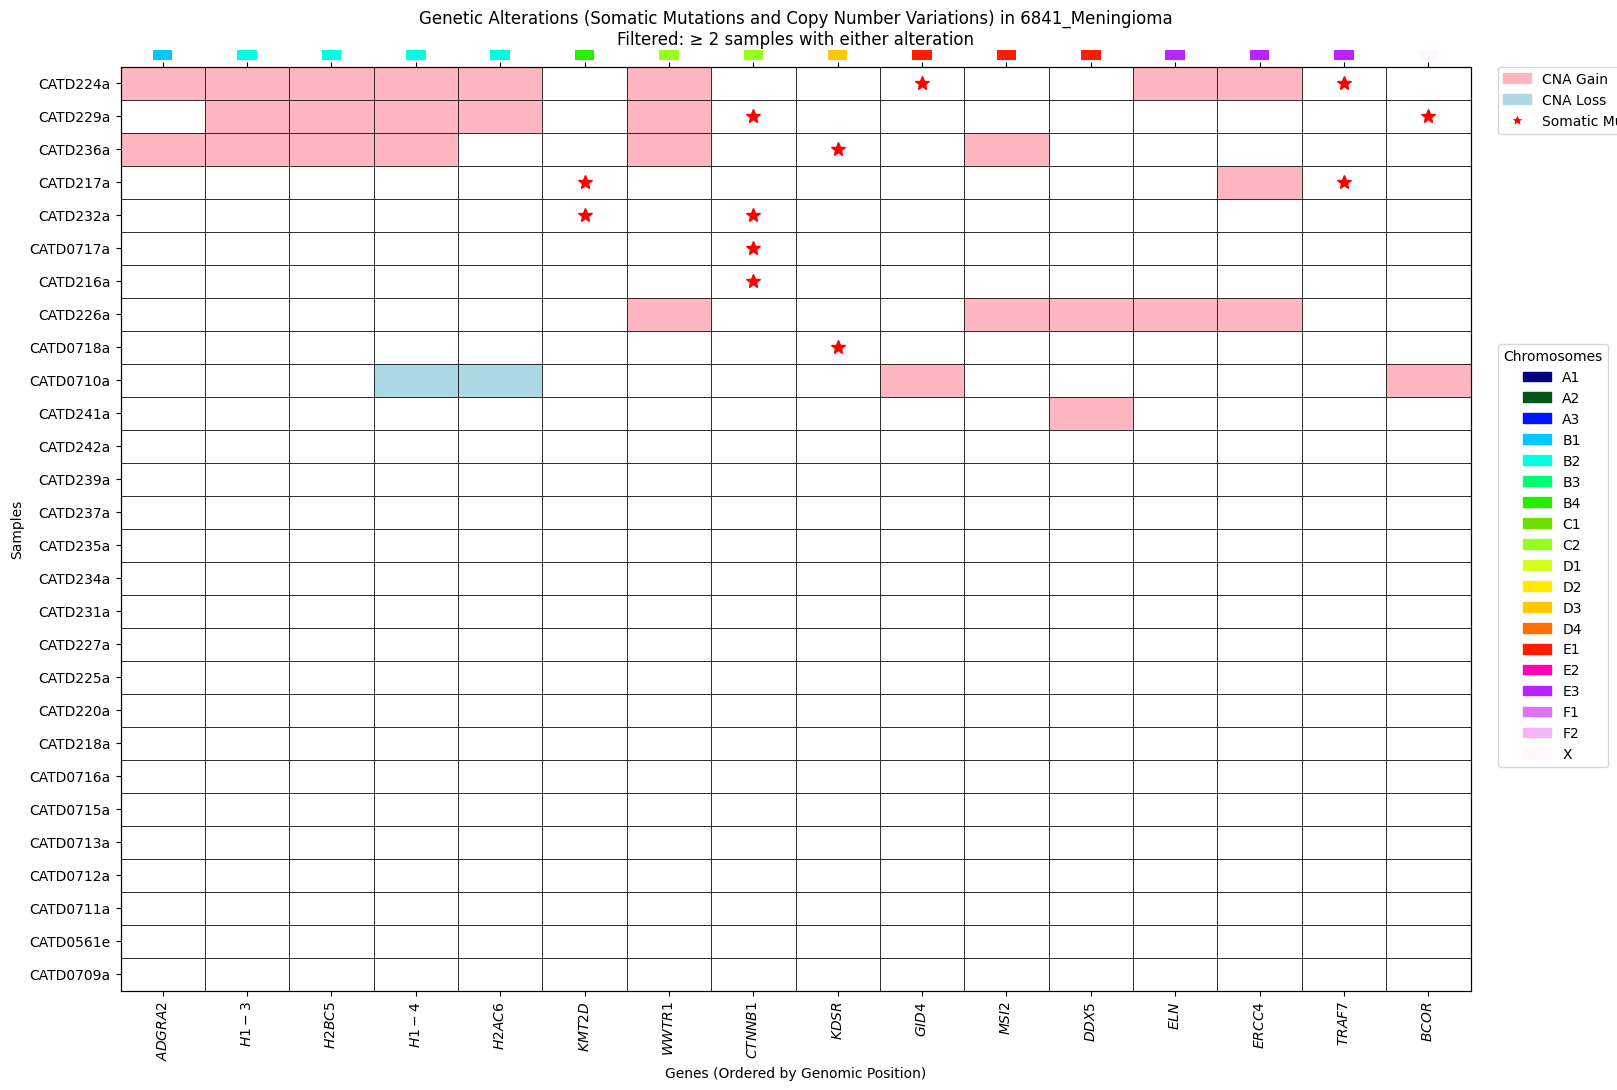

In [17]:
generate_recurrent_gene_oncoprint(
    maf_file=maf_files[4],
    cnv_file=cnv_files[4],
    tumour_type=get_study_name(cnv_files[4]),
    num_recurrent_samples=2,
    gene_chrom_file="/lustre/scratch127/bf14/analysis/fur_cnvkit/oncoprints/Felis_catus_9.0.gene_chromosome_mapping.txt",
    gene_sort="position",
    cluster_samples_flag=True,
    output_file=f"{get_study_name(cnv_files[4])}_oncoprint.pdf",
    breakdown_file=f"{get_study_name(cnv_files[4])}_oncoprint_breakdown.csv",
    exclude_file="/lustre/scratch127/bf14/metadata/FUR_cat.samples_to_exclude.nucleotide_variants.txt"
)

Breakdown table written to 6864_Pancreatic_carcinoma_oncoprint_breakdown.csv


/tmp/ipykernel_1765869/3466254326.py:232: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('gist_ncar', N)


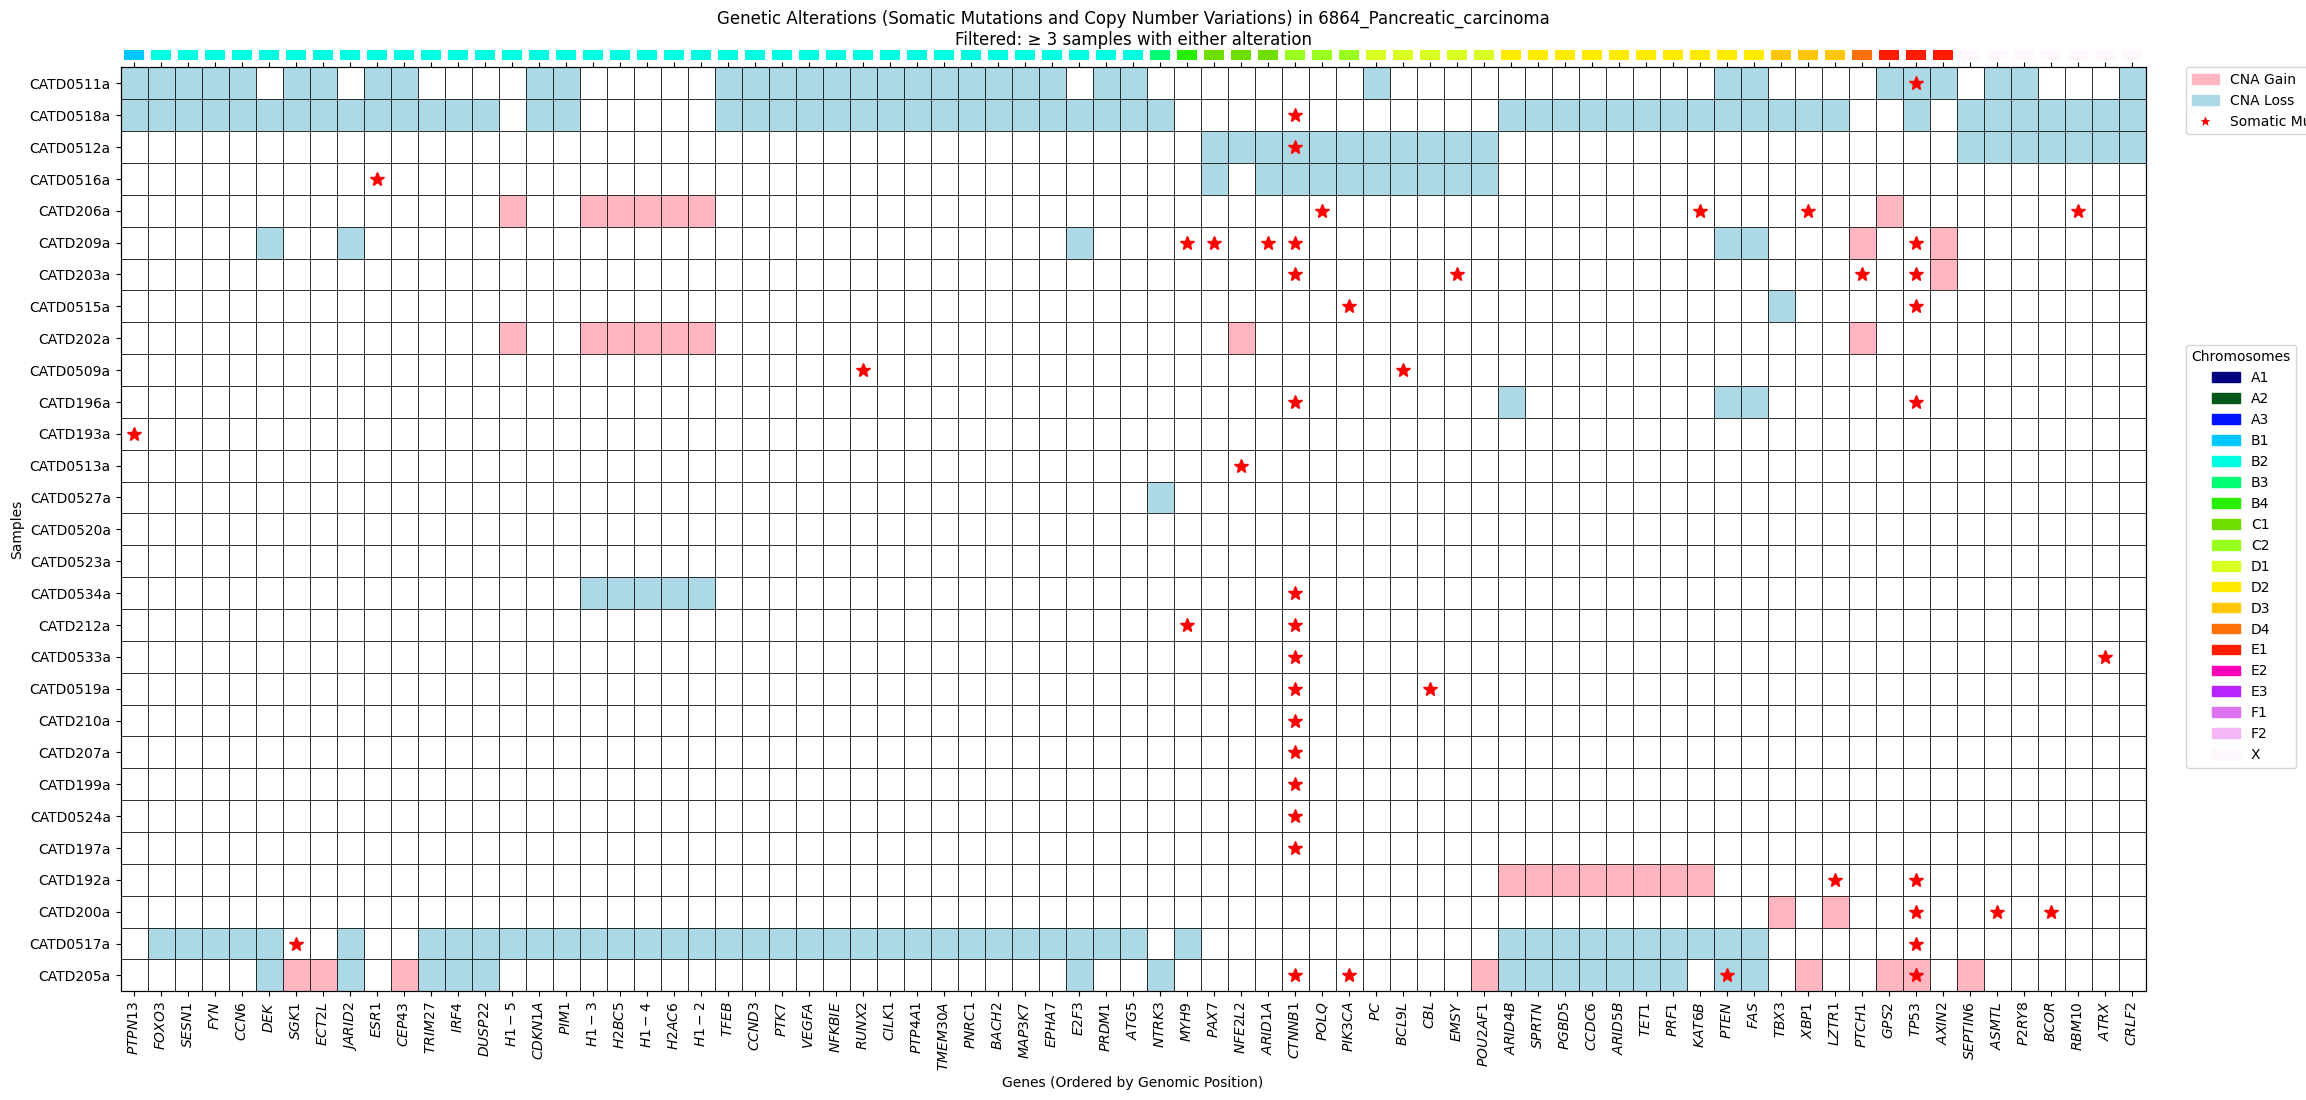

In [18]:
generate_recurrent_gene_oncoprint(
    maf_file=maf_files[5],
    cnv_file=cnv_files[5],
    tumour_type=get_study_name(cnv_files[5]),
    num_recurrent_samples=3,
    gene_chrom_file="/lustre/scratch127/bf14/analysis/fur_cnvkit/oncoprints/Felis_catus_9.0.gene_chromosome_mapping.txt",
    gene_sort="position",
    cluster_samples_flag=True,
    output_file=f"{get_study_name(cnv_files[5])}_oncoprint.pdf",
    breakdown_file=f"{get_study_name(cnv_files[5])}_oncoprint_breakdown.csv",
    plot_width=30,
    exclude_file="/lustre/scratch127/bf14/metadata/FUR_cat.samples_to_exclude.nucleotide_variants.txt"
)

Breakdown table written to 6945_Cholangiocarcinoma_oncoprint_breakdown.csv


/tmp/ipykernel_1765869/3466254326.py:232: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('gist_ncar', N)


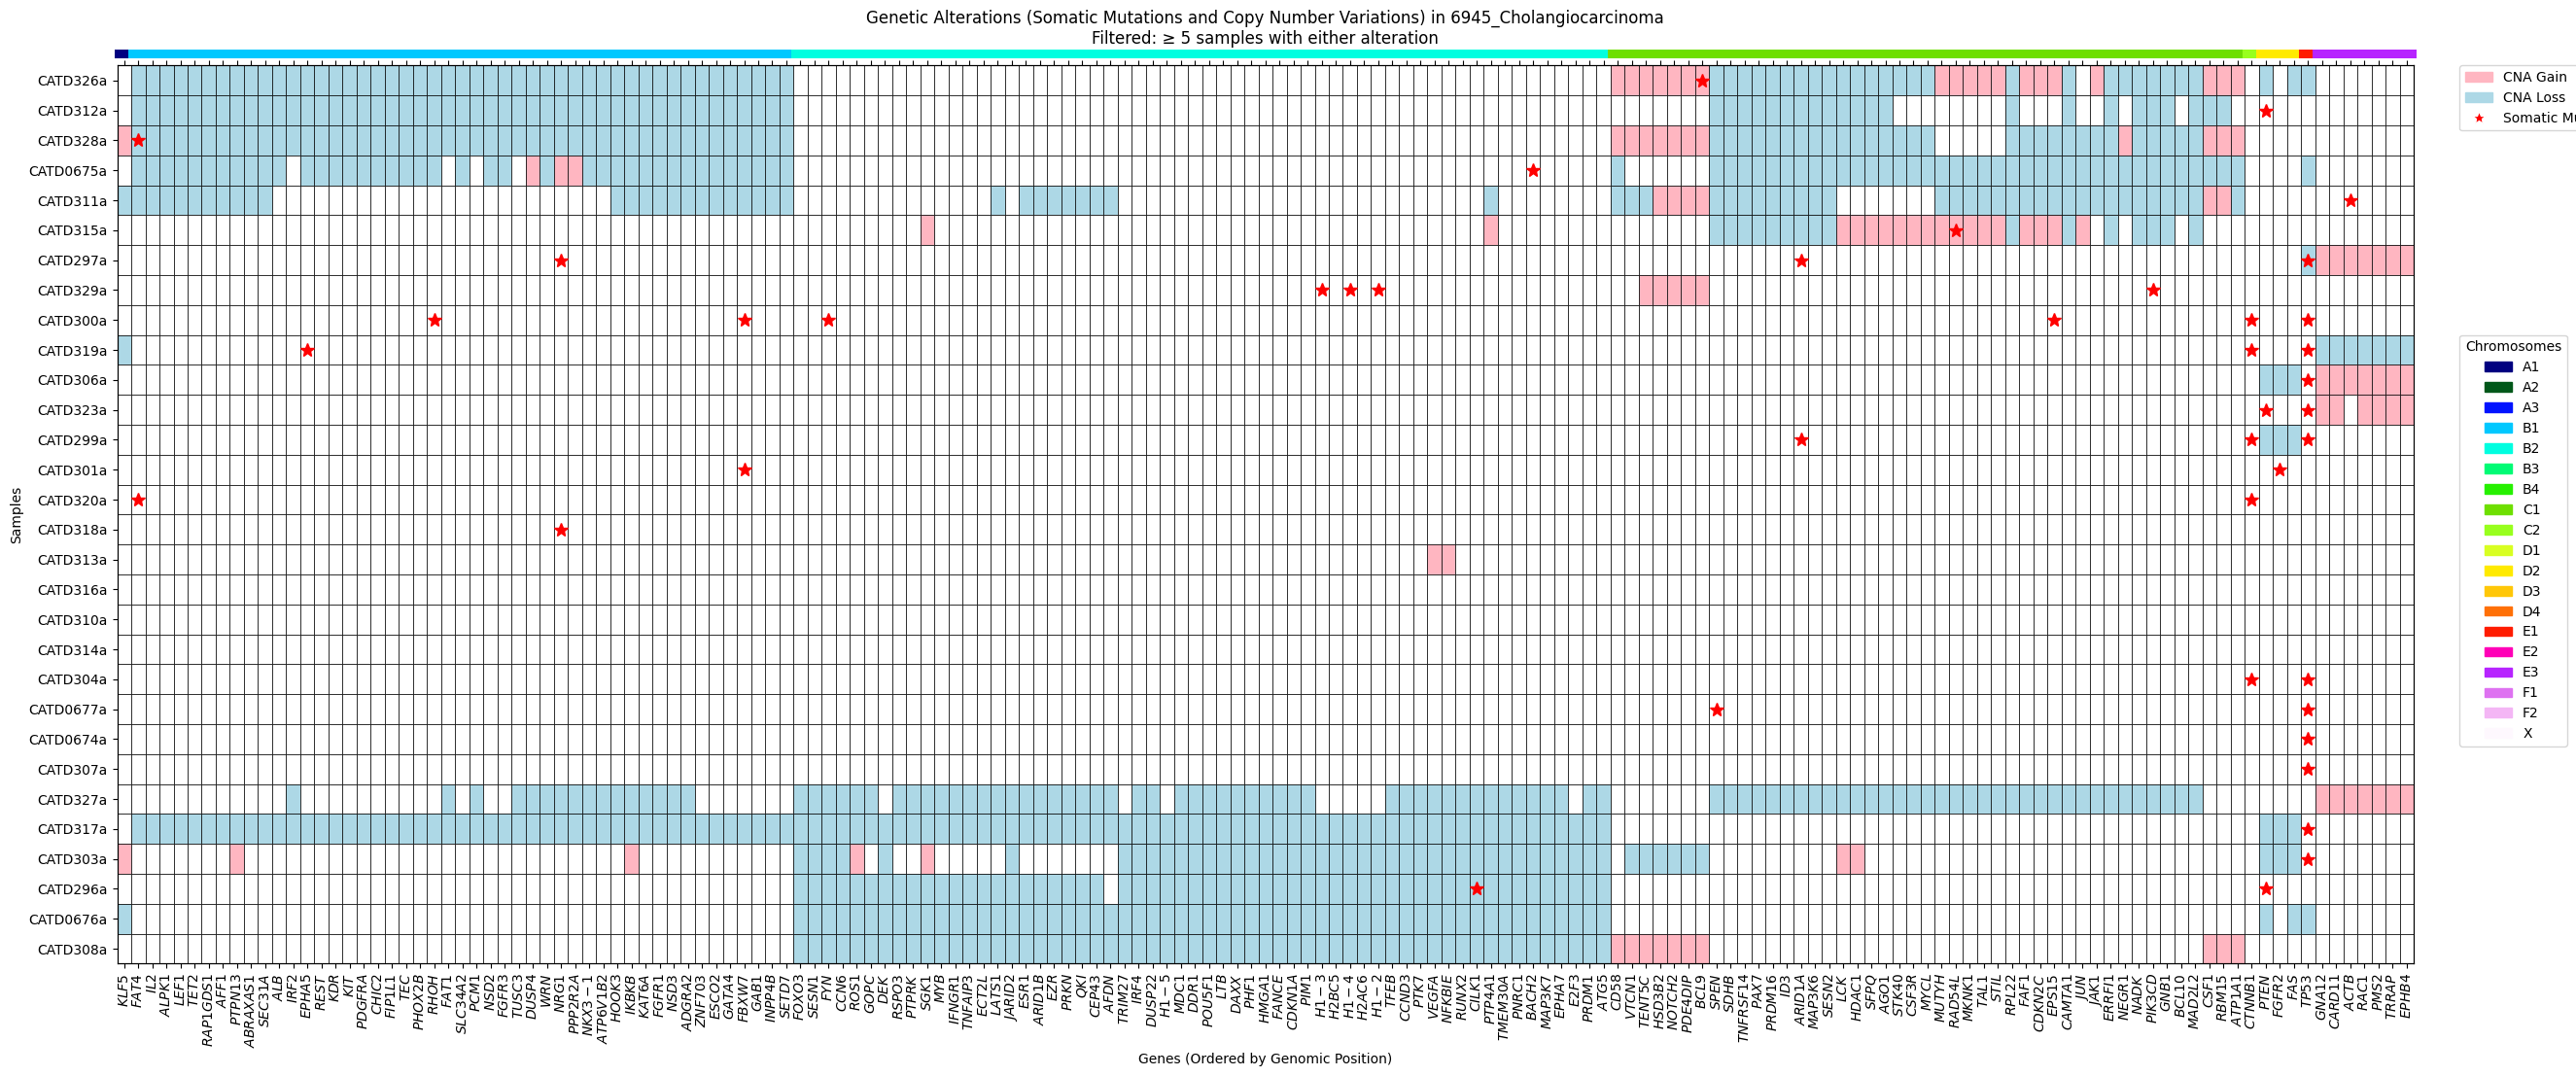

In [19]:
generate_recurrent_gene_oncoprint(
    maf_file=maf_files[6],
    cnv_file=cnv_files[6],
    tumour_type=get_study_name(cnv_files[6]),
    num_recurrent_samples=5,
    gene_chrom_file="/lustre/scratch127/bf14/analysis/fur_cnvkit/oncoprints/Felis_catus_9.0.gene_chromosome_mapping.txt",
    gene_sort="position",
    cluster_samples_flag=True,
    output_file=f"{get_study_name(cnv_files[6])}_oncoprint.pdf",
    breakdown_file=f"{get_study_name(cnv_files[6])}_oncoprint_breakdown.csv",
    plot_width=35,
    exclude_file="/lustre/scratch127/bf14/metadata/FUR_cat.samples_to_exclude.nucleotide_variants.txt"
)

Breakdown table written to 6973_OSA_oncoprint_breakdown.csv


/tmp/ipykernel_1765869/3466254326.py:232: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('gist_ncar', N)


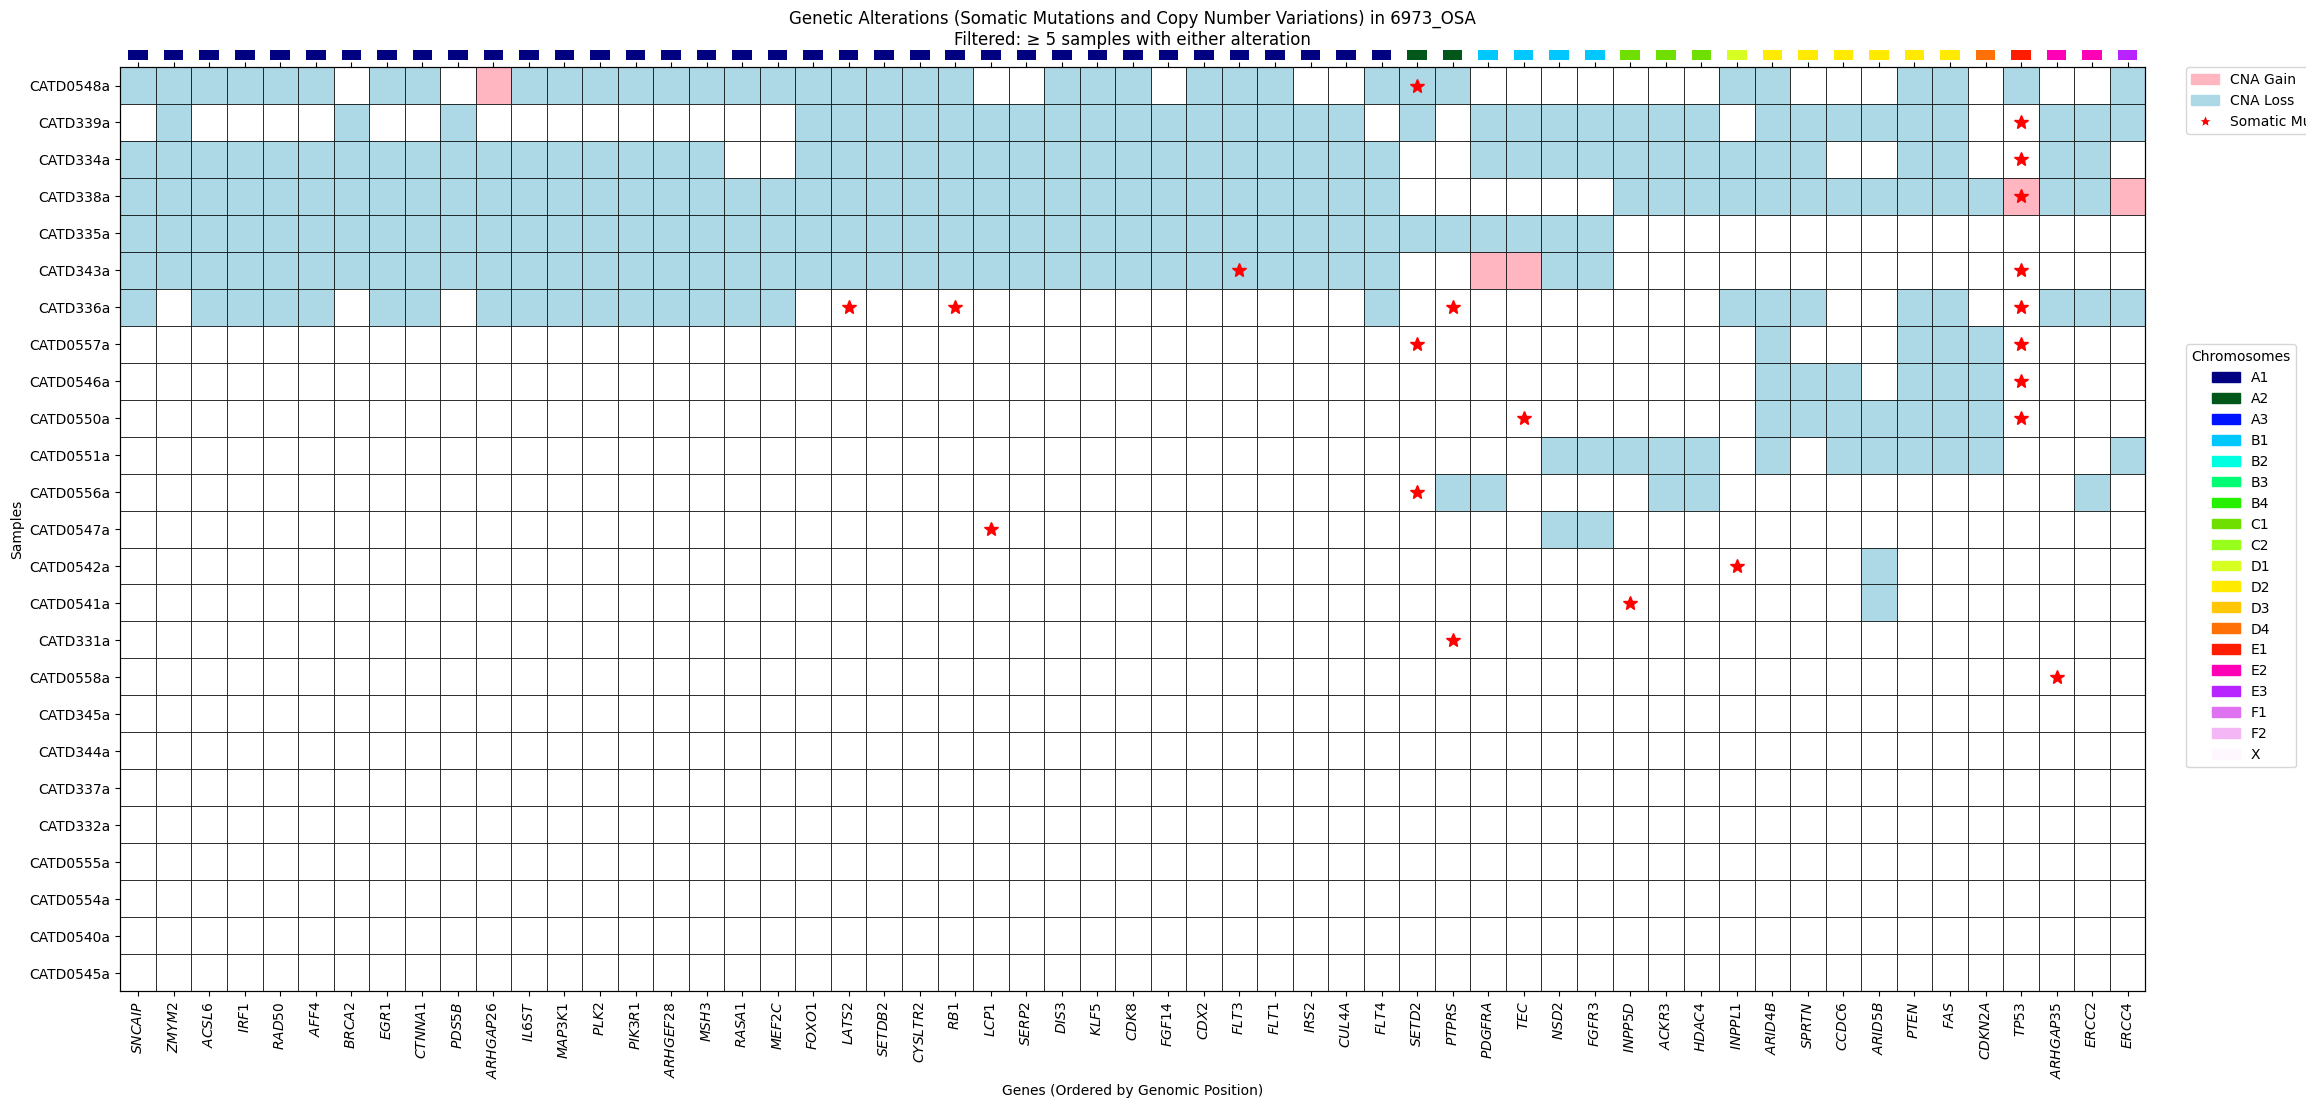

In [20]:
generate_recurrent_gene_oncoprint(
    maf_file=maf_files[7],
    cnv_file=cnv_files[7],
    tumour_type=get_study_name(cnv_files[7]),
    num_recurrent_samples=5,
    gene_chrom_file="/lustre/scratch127/bf14/analysis/fur_cnvkit/oncoprints/Felis_catus_9.0.gene_chromosome_mapping.txt",
    gene_sort="position",
    cluster_samples_flag=True,
    output_file=f"{get_study_name(cnv_files[7])}_oncoprint.pdf",
    breakdown_file=f"{get_study_name(cnv_files[7])}_oncoprint_breakdown.csv",
    plot_width=30,
    exclude_file="/lustre/scratch127/bf14/metadata/FUR_cat.samples_to_exclude.nucleotide_variants.txt"
)

Breakdown table written to 6982_Lymphoma_oncoprint_breakdown.csv


/tmp/ipykernel_1765869/3466254326.py:232: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('gist_ncar', N)


Breakdown table written to T_cell_lymphoma_breakdown.csv


/tmp/ipykernel_1765869/3466254326.py:232: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('gist_ncar', N)


Breakdown table written to B_cell_lymphoma_breakdown.csv


/tmp/ipykernel_1765869/3466254326.py:232: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('gist_ncar', N)


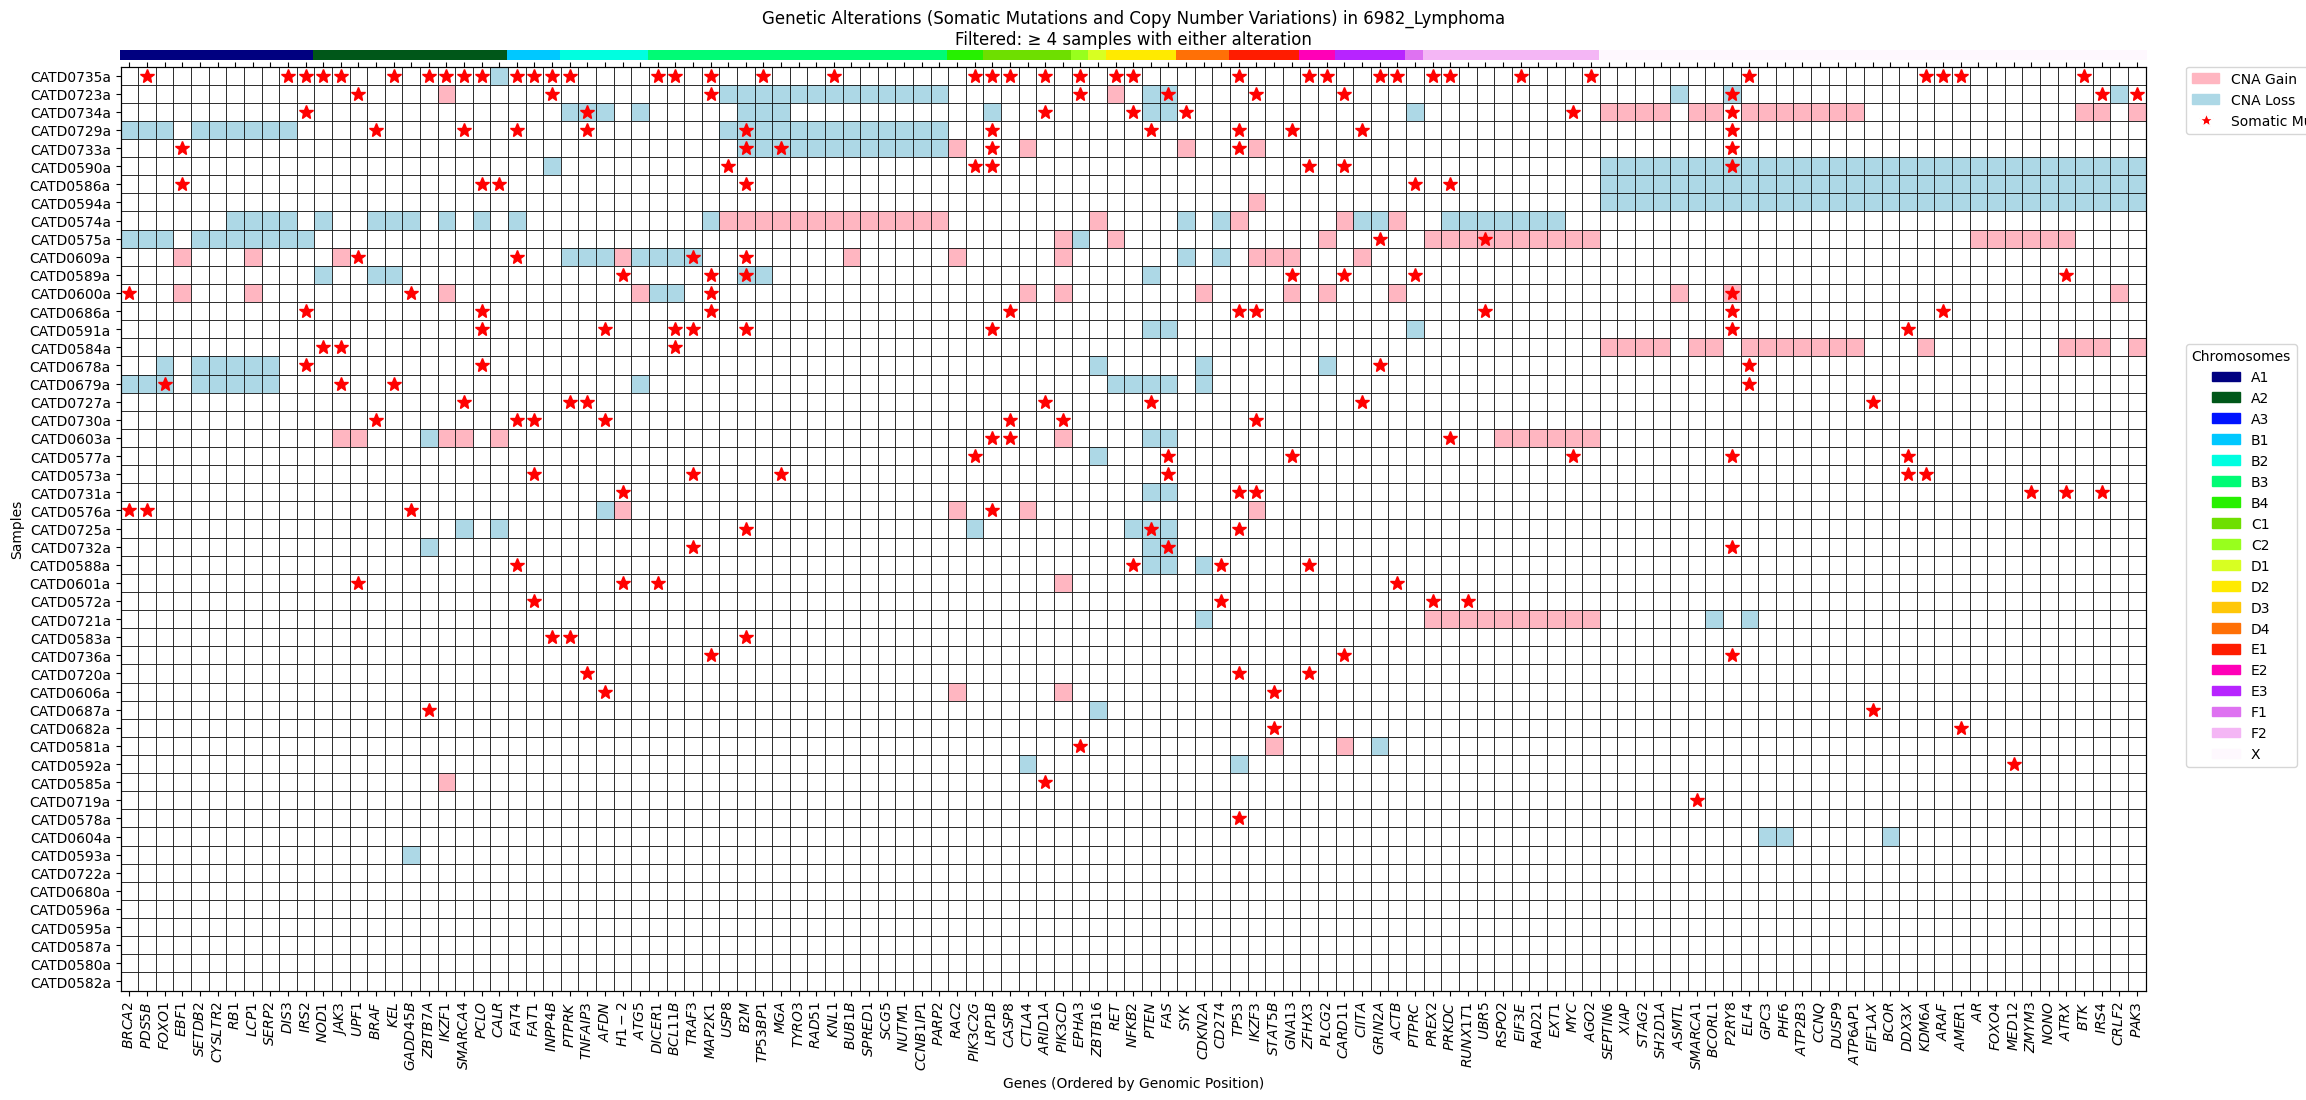

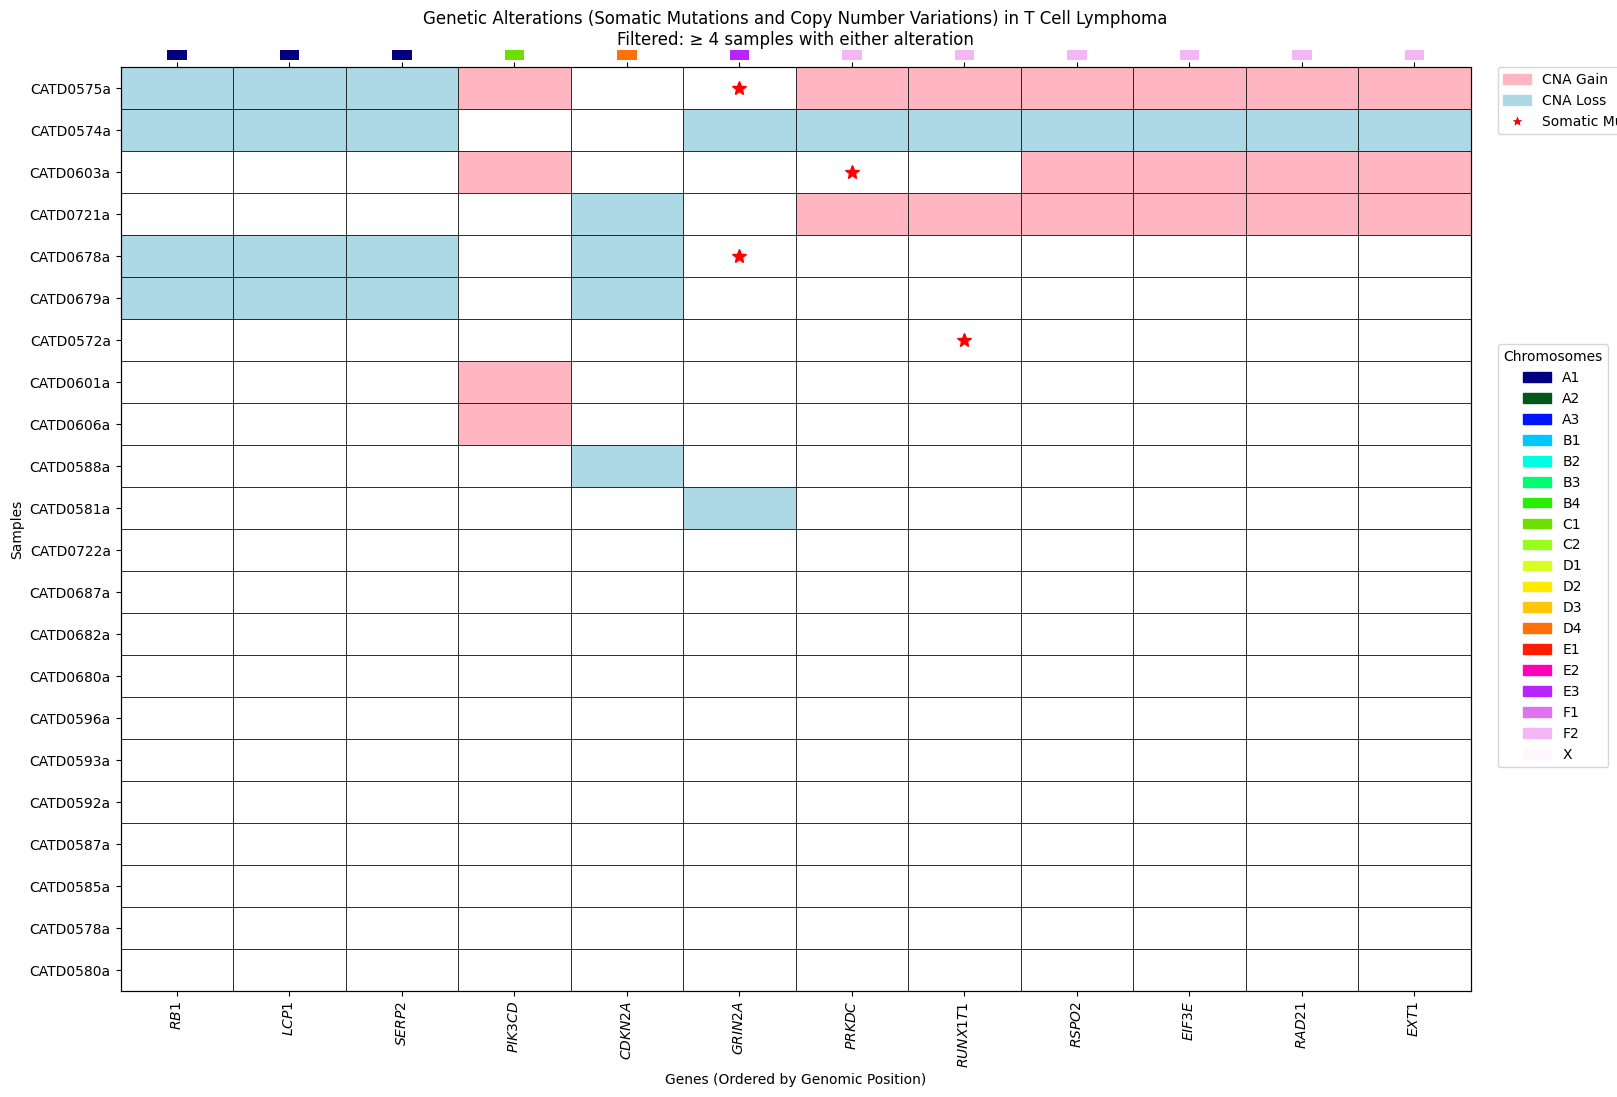

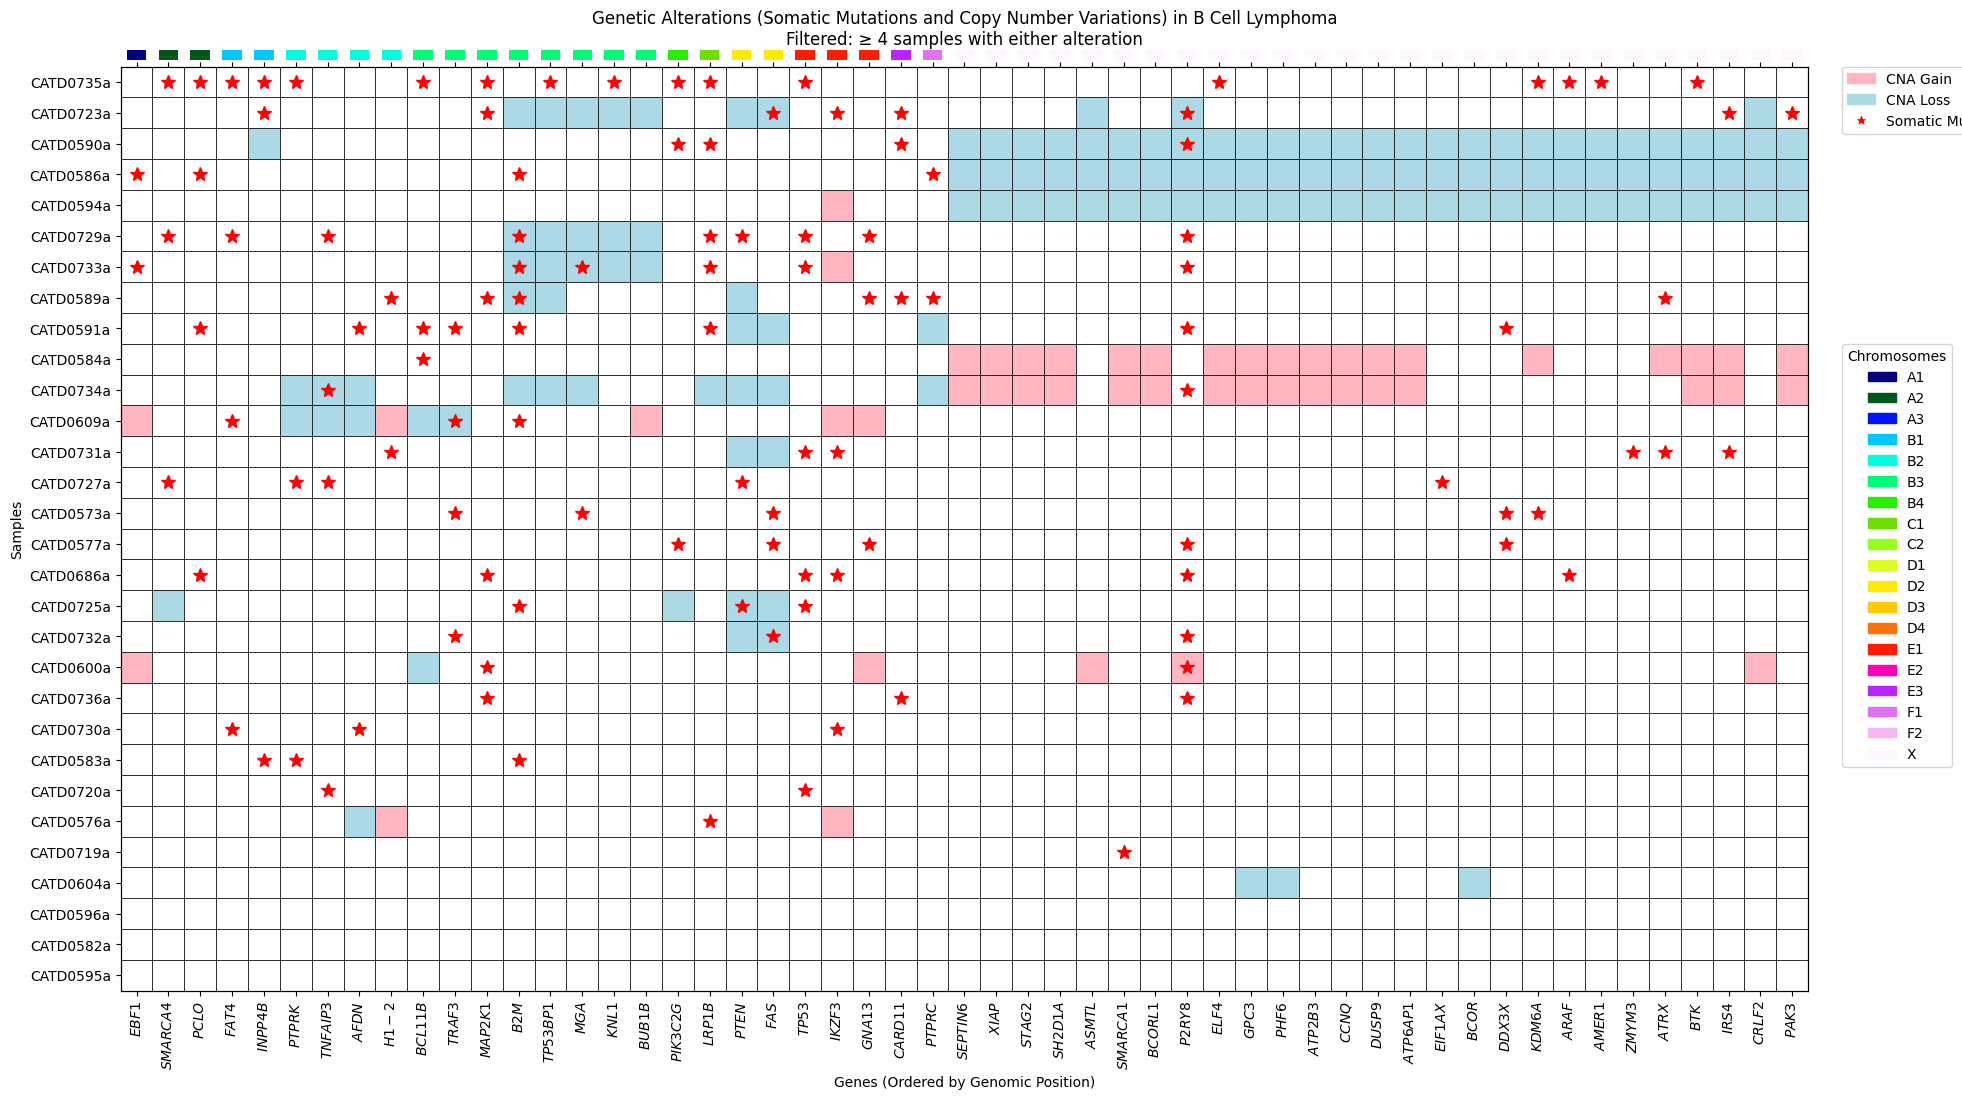

In [21]:
# Overall lymphoma plot (using all samples)
generate_recurrent_gene_oncoprint(
    maf_file=maf_files[8],
    cnv_file=cnv_files[8],
    tumour_type=get_study_name(cnv_files[8]),
    num_recurrent_samples=4,
    gene_chrom_file="/lustre/scratch127/bf14/analysis/fur_cnvkit/oncoprints/Felis_catus_9.0.gene_chromosome_mapping.txt",
    gene_sort="position",
    cluster_samples_flag=True,
    output_file=f"{get_study_name(cnv_files[8])}_oncoprint.pdf",
    breakdown_file=f"{get_study_name(cnv_files[8])}_oncoprint_breakdown.csv",
    plot_width=30,
    exclude_file="/lustre/scratch127/bf14/metadata/FUR_cat.samples_to_exclude.nucleotide_variants.txt"
)

# Define sample lists
T_CELL_LYMPHOMA_SAMPLES = [
    'CATD0572a', 'CATD0574a', 'CATD0575a',
    'CATD0578a', 'CATD0579a', 'CATD0580a', 
    'CATD0581a', 'CATD0585a', 'CATD0587a',
    'CATD0588a', 'CATD0592a', 'CATD0593a',
    'CATD0596a', 'CATD0598a', 'CATD0601a',
    'CATD0603a', 'CATD0606a', 'CATD0608a',
    'CATD0610a', 'CATD0678a', 'CATD0679a',
    'CATD0680a', 'CATD0682a', 'CATD0683a', 
    'CATD0684a', 'CATD0687a', 'CATD0721a',
    'CATD0722a', 'CATD0724a'
]
NK_LYMPHOMA_SAMPLES = ["CATD0596a"]

# For T cell plot: use T cell ∪ NK samples.
t_cell_samples = list(set(T_CELL_LYMPHOMA_SAMPLES) | set(NK_LYMPHOMA_SAMPLES))
generate_recurrent_gene_oncoprint(
    maf_file=maf_files[8],
    cnv_file=cnv_files[8],
    tumour_type="T Cell Lymphoma",
    num_recurrent_samples=4,
    gene_chrom_file="/lustre/scratch127/bf14/analysis/fur_cnvkit/oncoprints/Felis_catus_9.0.gene_chromosome_mapping.txt",
    gene_sort="position",
    cluster_samples_flag=True,
    output_file="T_cell_lymphoma_oncoprint.pdf",
    breakdown_file="T_cell_lymphoma_breakdown.csv",
    include_samples=t_cell_samples,
    exclude_file="/lustre/scratch127/bf14/metadata/FUR_cat.samples_to_exclude.nucleotide_variants.txt"
)

all_lymphoma_samples = [
    "CATD0572a",
    "CATD0573a",
    "CATD0574a",
    "CATD0575a",
    "CATD0576a",
    "CATD0577a",
    "CATD0578a",
    "CATD0580a",
    "CATD0581a",
    "CATD0582a",
    "CATD0583a",
    "CATD0584a",
    "CATD0585a",
    "CATD0586a",
    "CATD0587a",
    "CATD0588a",
    "CATD0589a",
    "CATD0590a",
    "CATD0591a",
    "CATD0592a",
    "CATD0593a",
    "CATD0594a",
    "CATD0595a",
    "CATD0596a",
    "CATD0600a",
    "CATD0601a",
    "CATD0603a",
    "CATD0604a",
    "CATD0606a",
    "CATD0609a",
    "CATD0678a",
    "CATD0679a",
    "CATD0680a",
    "CATD0682a",
    "CATD0686a",
    "CATD0687a",
    "CATD0719a",
    "CATD0720a",
    "CATD0721a",
    "CATD0722a",
    "CATD0723a",
    "CATD0725a",
    "CATD0727a",
    "CATD0729a",
    "CATD0730a",
    "CATD0731a",
    "CATD0732a",
    "CATD0733a",
    "CATD0734a",
    "CATD0735a",
    "CATD0736a"
]

b_cell_samples = list((set(all_lymphoma_samples) - set(T_CELL_LYMPHOMA_SAMPLES)) | set(NK_LYMPHOMA_SAMPLES))

generate_recurrent_gene_oncoprint(
    maf_file=maf_files[8],
    cnv_file=cnv_files[8],
    tumour_type="B Cell Lymphoma",
    num_recurrent_samples=4,
    gene_chrom_file="/lustre/scratch127/bf14/analysis/fur_cnvkit/oncoprints/Felis_catus_9.0.gene_chromosome_mapping.txt",
    gene_sort="position",
    cluster_samples_flag=True,
    output_file="B_cell_lymphoma_oncoprint.pdf",
    breakdown_file="B_cell_lymphoma_breakdown.csv",
    plot_width=25,
    include_samples=b_cell_samples,
    exclude_file="/lustre/scratch127/bf14/metadata/FUR_cat.samples_to_exclude.nucleotide_variants.txt"
)


Breakdown table written to 6990_Mammary_carcinoma_oncoprint_breakdown.csv


/tmp/ipykernel_1765869/3466254326.py:232: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('gist_ncar', N)


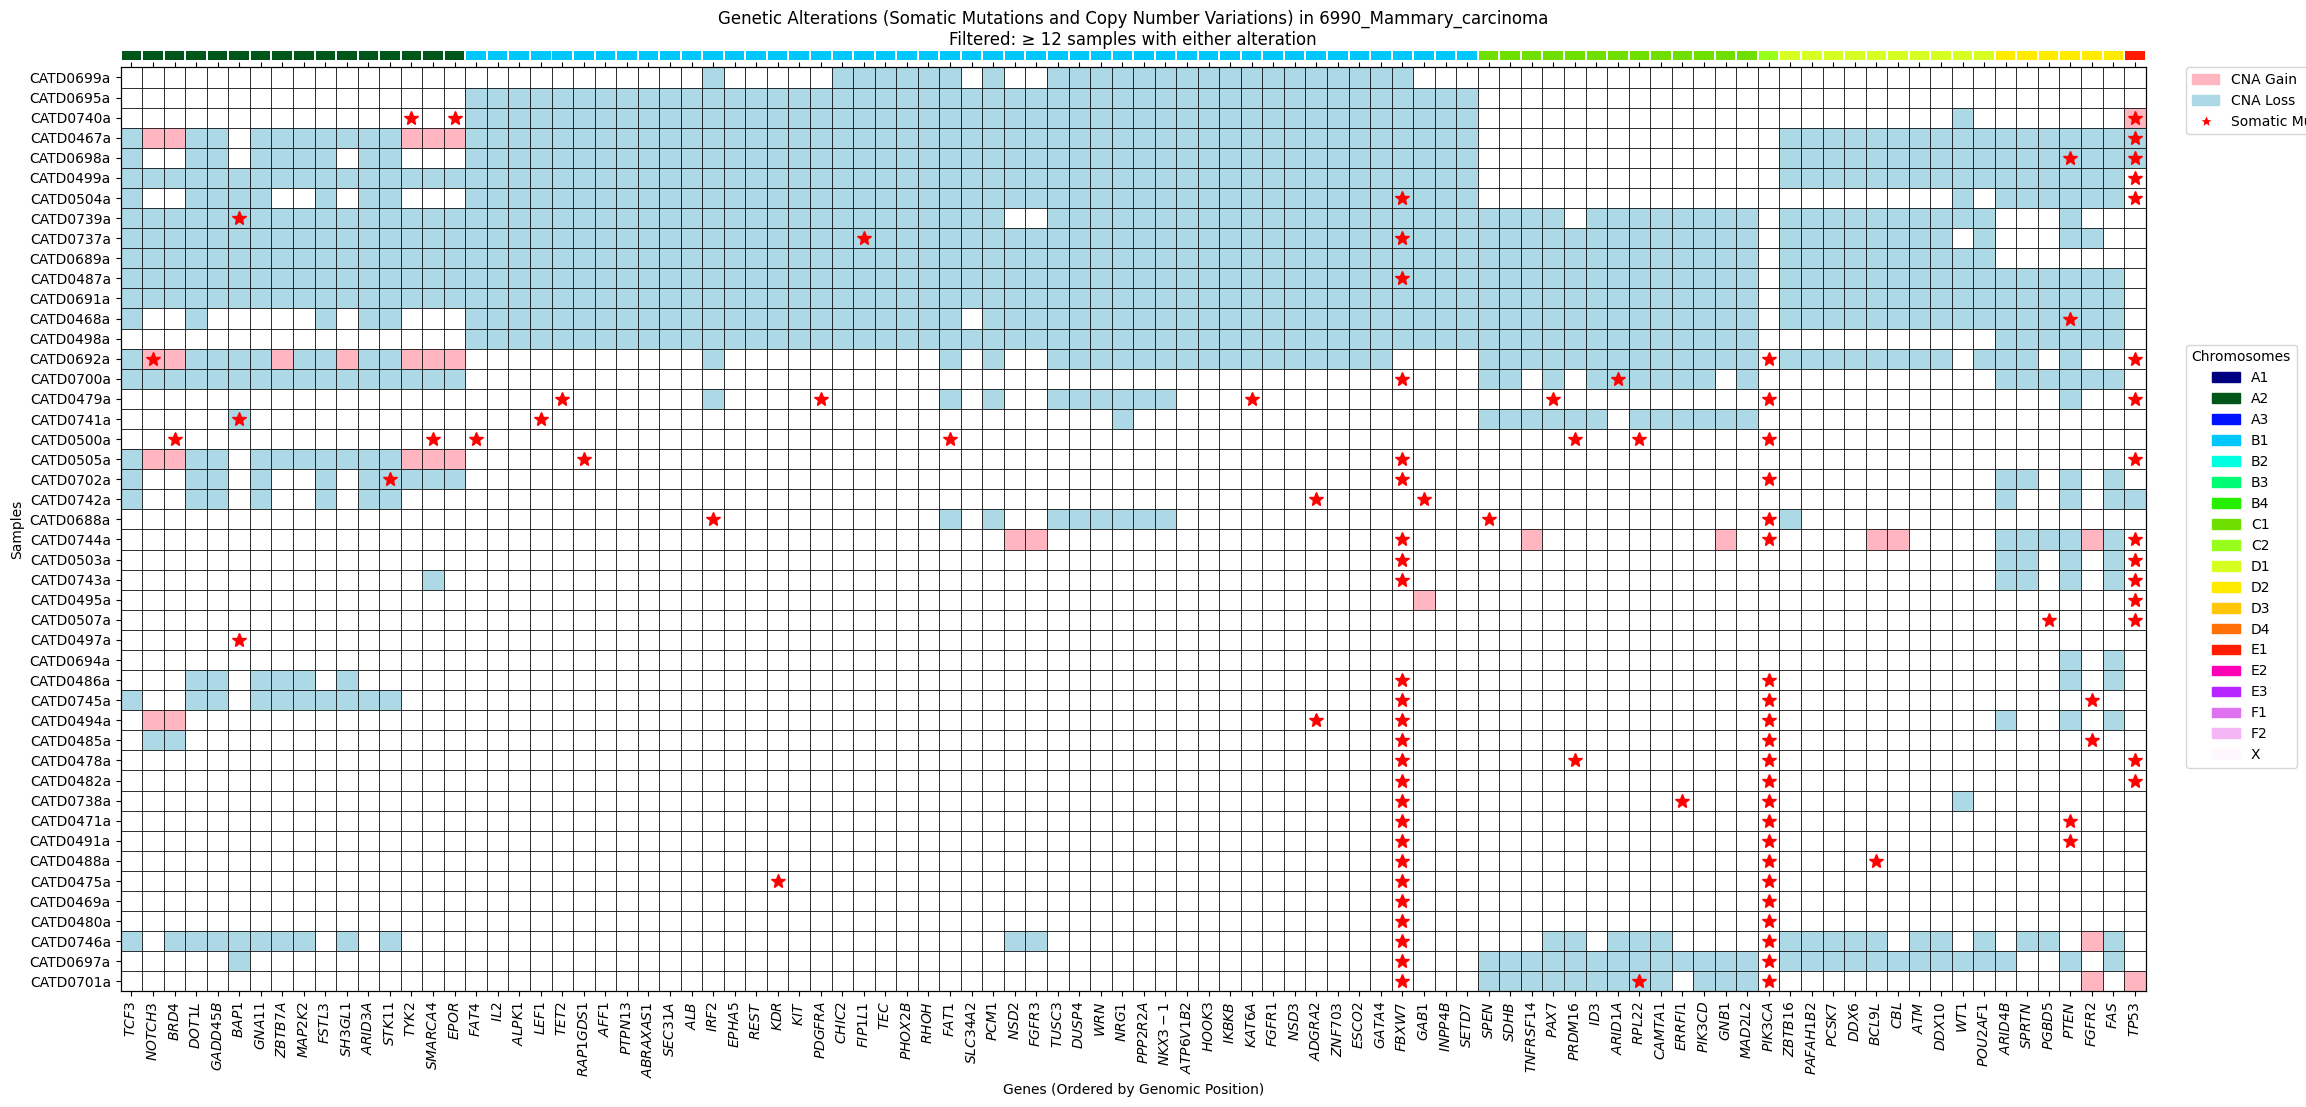

In [22]:
generate_recurrent_gene_oncoprint(
    maf_file=maf_files[9],
    cnv_file=cnv_files[9],
    tumour_type=get_study_name(cnv_files[9]),
    num_recurrent_samples=12,
    gene_chrom_file="/lustre/scratch127/bf14/analysis/fur_cnvkit/oncoprints/Felis_catus_9.0.gene_chromosome_mapping.txt",
    gene_sort="position",
    cluster_samples_flag=True,
    output_file=f"{get_study_name(cnv_files[9])}_oncoprint.pdf",
    breakdown_file=f"{get_study_name(cnv_files[9])}_oncoprint_breakdown.csv",
    plot_width=30,
    exclude_file="/lustre/scratch127/bf14/metadata/FUR_cat.samples_to_exclude.nucleotide_variants.txt"
)

Breakdown table written to 7040_BCC_oncoprint_breakdown.csv


/tmp/ipykernel_1765869/3466254326.py:232: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('gist_ncar', N)


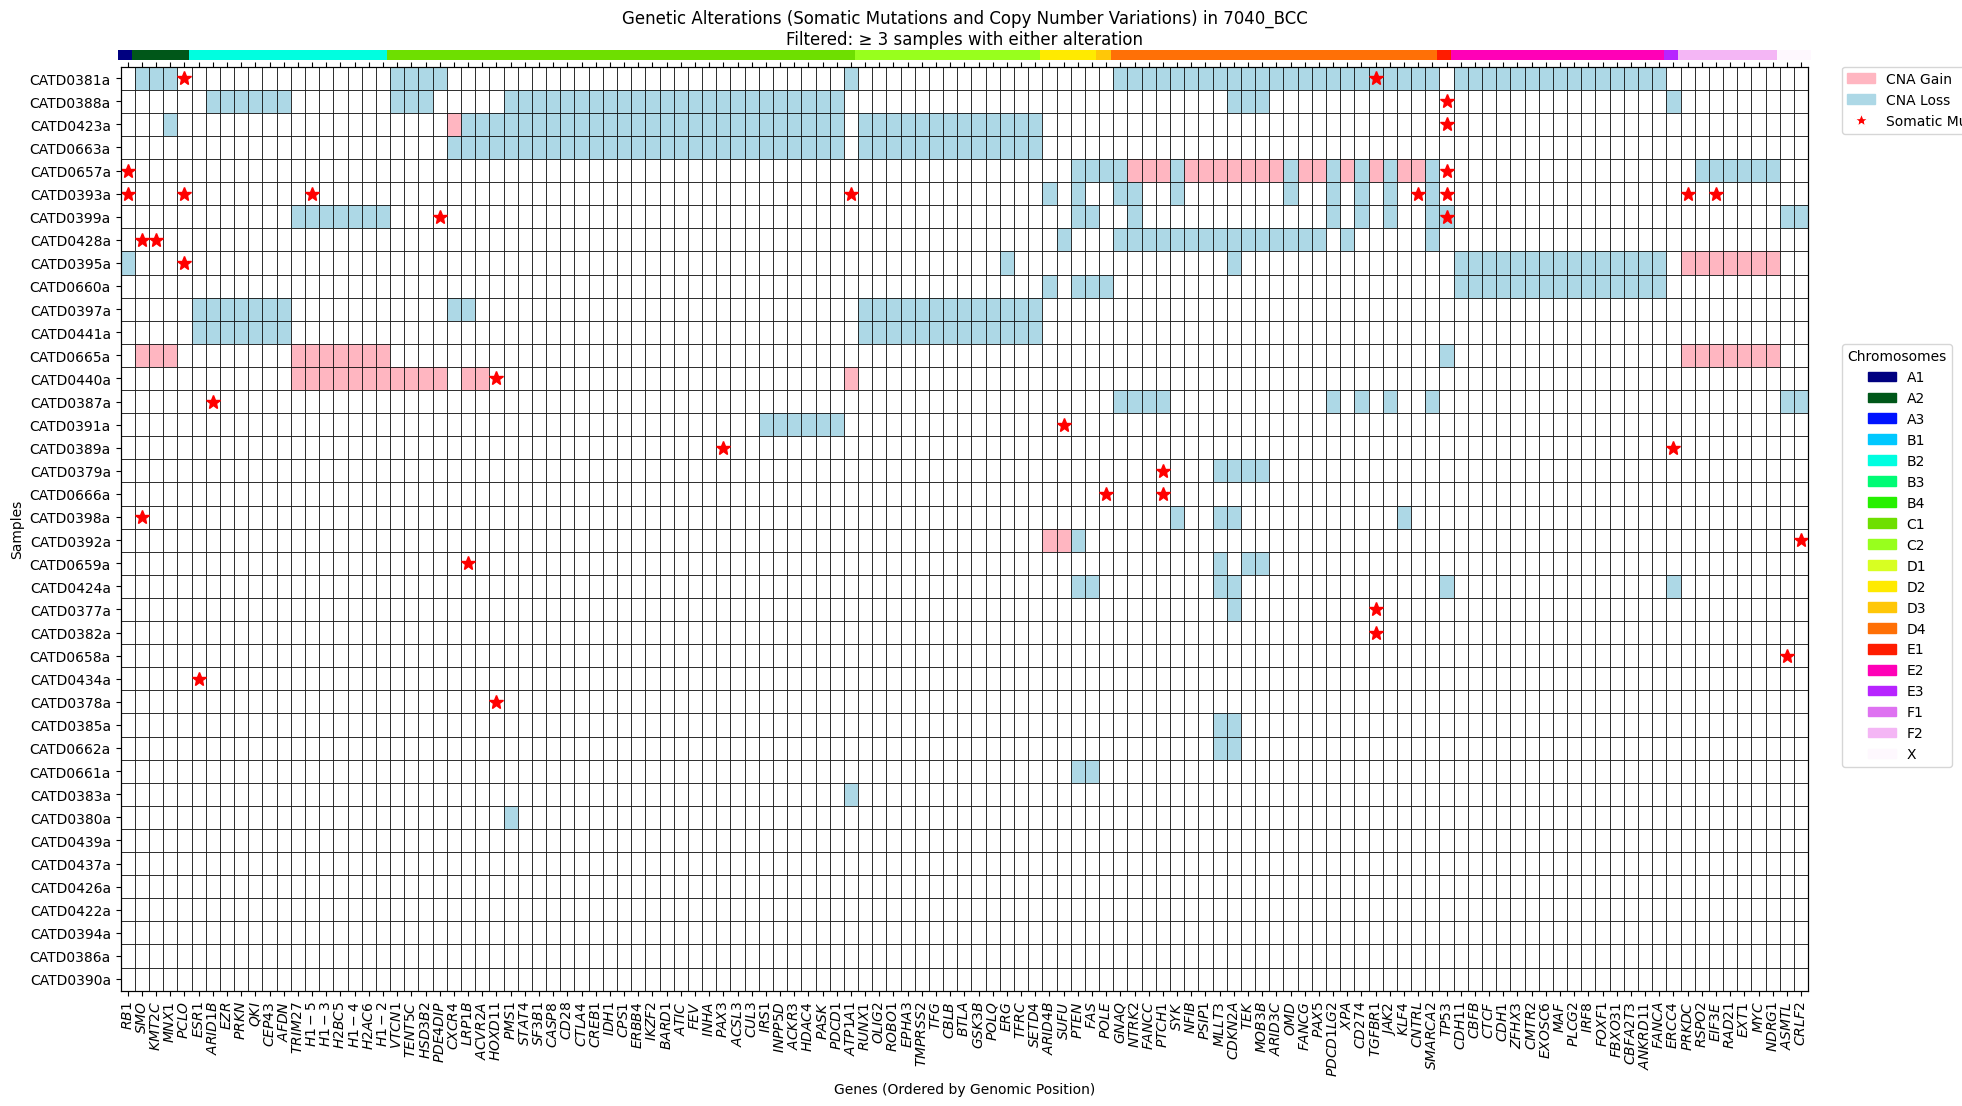

In [23]:
generate_recurrent_gene_oncoprint(
    maf_file=maf_files[10],
    cnv_file=cnv_files[10],
    tumour_type=get_study_name(cnv_files[10]),
    num_recurrent_samples=3,
    gene_chrom_file="/lustre/scratch127/bf14/analysis/fur_cnvkit/oncoprints/Felis_catus_9.0.gene_chromosome_mapping.txt",
    gene_sort="position",
    cluster_samples_flag=True,
    output_file=f"{get_study_name(cnv_files[10])}_oncoprint.pdf",
    breakdown_file=f"{get_study_name(cnv_files[10])}_oncoprint_breakdown.csv",
    plot_width=25,
    exclude_file="/lustre/scratch127/bf14/metadata/FUR_cat.samples_to_exclude.nucleotide_variants.txt"
)

Breakdown table written to 7097_CRC_oncoprint_breakdown.csv


/tmp/ipykernel_1765869/3466254326.py:232: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('gist_ncar', N)


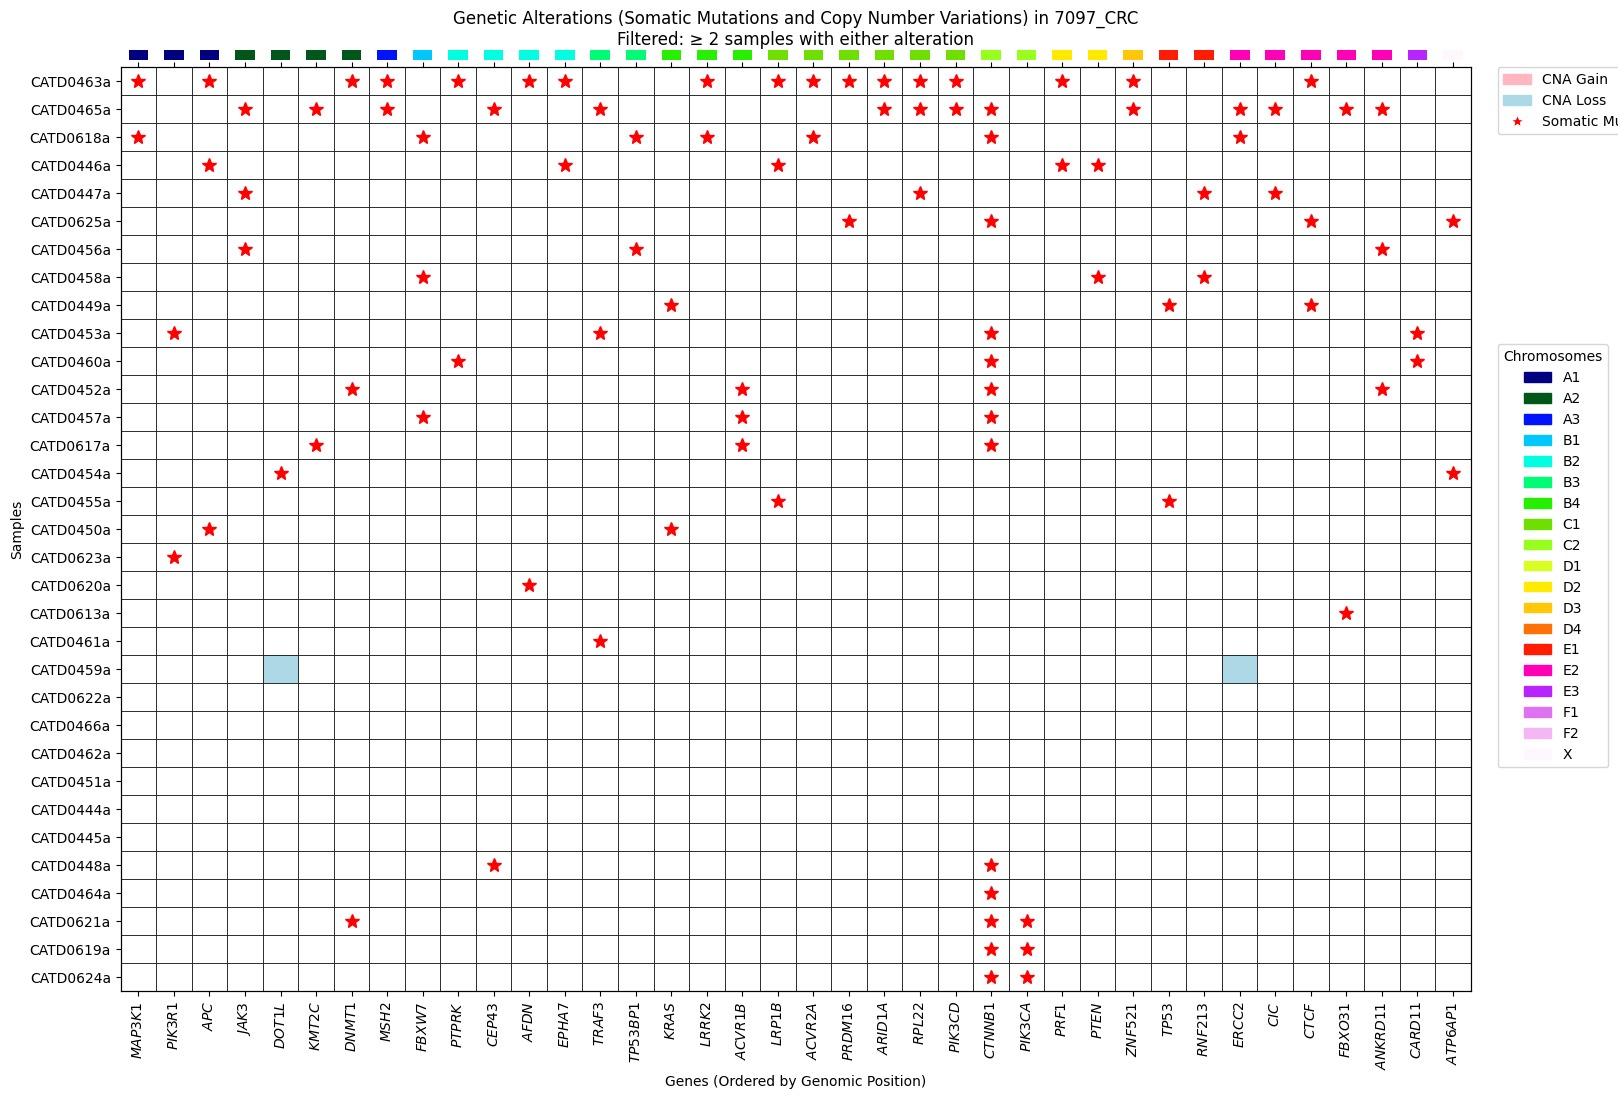

In [24]:
generate_recurrent_gene_oncoprint(
    maf_file=maf_files[11],
    cnv_file=cnv_files[11],
    tumour_type=get_study_name(cnv_files[11]),
    num_recurrent_samples=2,
    gene_chrom_file="/lustre/scratch127/bf14/analysis/fur_cnvkit/oncoprints/Felis_catus_9.0.gene_chromosome_mapping.txt",
    gene_sort="position",
    cluster_samples_flag=True,
    output_file=f"{get_study_name(cnv_files[11])}_oncoprint.pdf",
    breakdown_file=f"{get_study_name(cnv_files[11])}_oncoprint_breakdown.csv",
    exclude_file="/lustre/scratch127/bf14/metadata/FUR_cat.samples_to_exclude.nucleotide_variants.txt"
)

Breakdown table written to 7098_Glioma_oncoprint_breakdown.csv


/tmp/ipykernel_1765869/3466254326.py:232: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('gist_ncar', N)


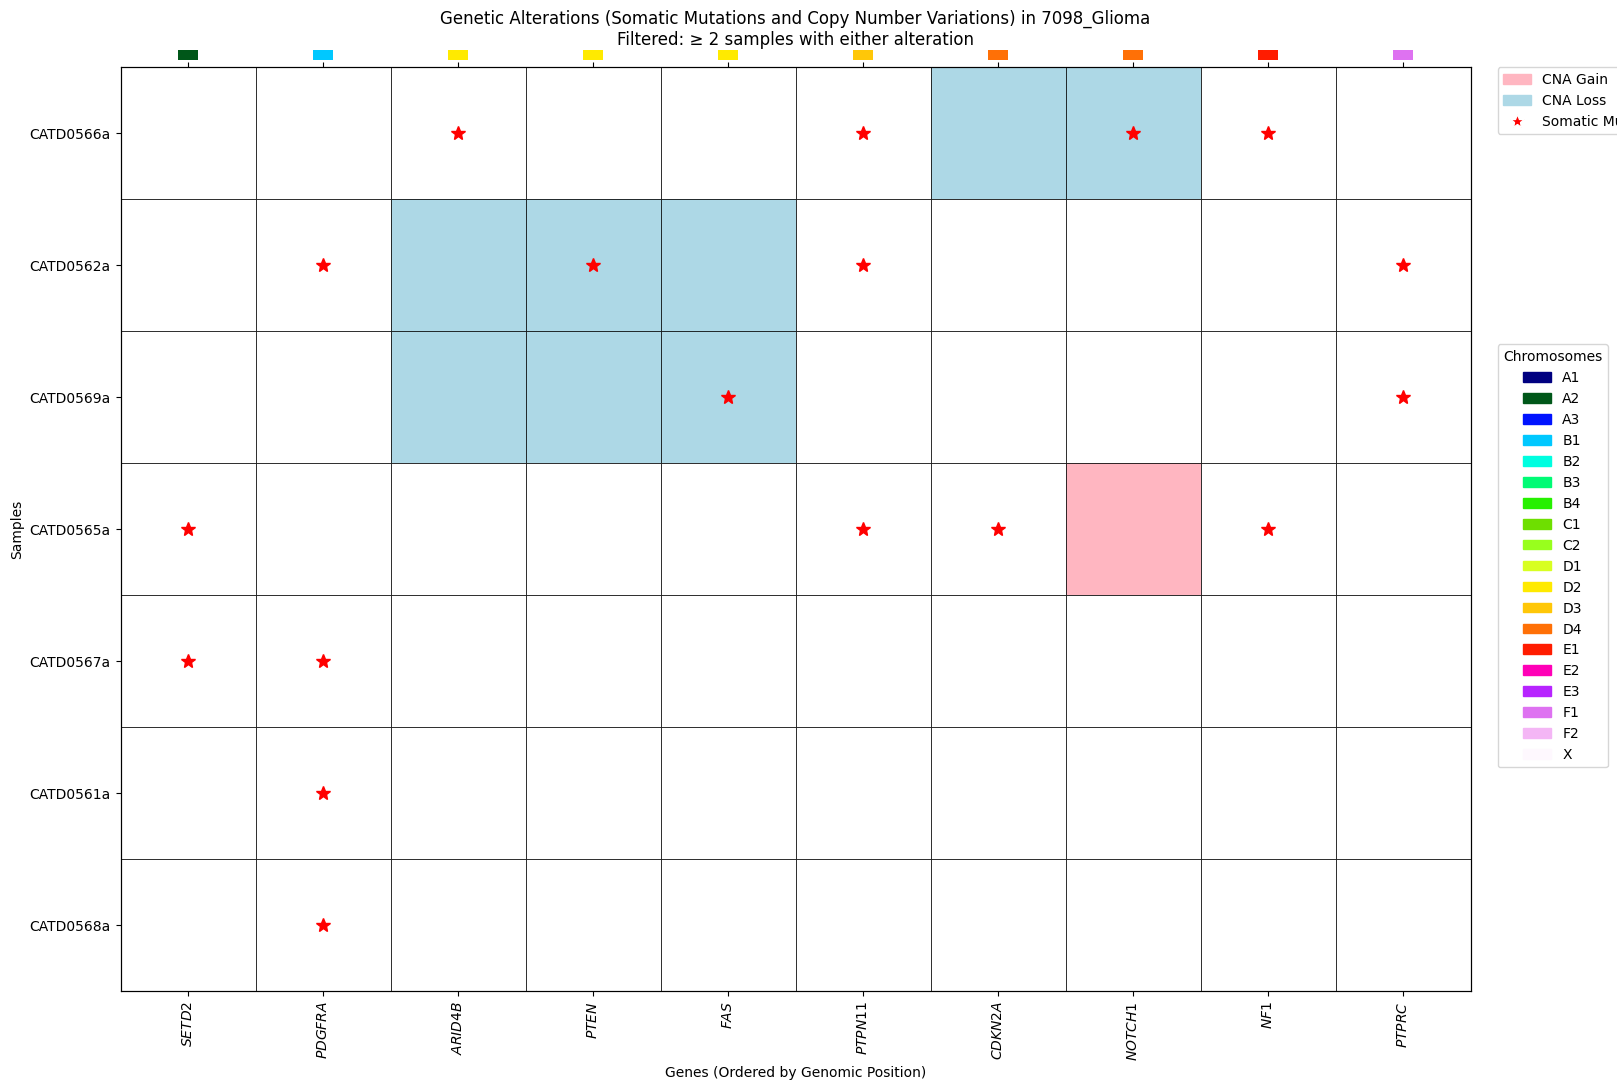

In [25]:
generate_recurrent_gene_oncoprint(
    maf_file=maf_files[12],
    cnv_file=cnv_files[12],
    tumour_type=get_study_name(cnv_files[12]),
    num_recurrent_samples=2,
    gene_chrom_file="/lustre/scratch127/bf14/analysis/fur_cnvkit/oncoprints/Felis_catus_9.0.gene_chromosome_mapping.txt",
    gene_sort="position",
    cluster_samples_flag=True,
    output_file=f"{get_study_name(cnv_files[12])}_oncoprint.pdf",
    breakdown_file=f"{get_study_name(cnv_files[12])}_oncoprint_breakdown.csv",
    exclude_file="/lustre/scratch127/bf14/metadata/FUR_cat.samples_to_exclude.nucleotide_variants.txt"
)